# **Introduction to EDA/Modelling for Multi-Class Prediction of Steel Plate Defect Prediction**

![easy_peasy_EDA](https://th.bing.com/th/id/OIG4.29yDnnolGaKxU7eV3Q.z?pid=ImgGn)

* ver 2  : 1st basic version
* ver 3  : added shap plots and feature engineering
* ver 4  : hyperparameter optimization by Optuna
* ver 9  : reverting to float64 due to rounding errors with float32
* ver 10 : added cv predictions, error analysis, shap summary by stacked bars
* ver 11 : added blending with a LightGBM model
* ver 12 : using Nelder-Mean optimization for best blend weights
* ver 13 : implemented individual target blend weight optimization
* ver 14 : testing multi:softprob
* ver 15 : reverting to softmax, updating LightGBM hyperparameters

The notebook deals with the competition Steel Plate Defect Prediction, Playground Season-4 Episode-2.

The notebook is structured as a series of cells and comments, from data exploration to building and optimizing a first starter model using XGBoost. By following it you can understabnd both the data problem and grasp the actions to be taken with similar tabular data problems.

The approach is to explore data using the essential commands for tabular and chart representations. Often, on Kaggle Notebooks for competitions, EDA is weighted with tons of charts and plots that you cannot understand what they serve for, based on the principle "The More The Merrier". The idea is instead to just go to the point and show the relevant plots and keyt understanding in a dataset that could help you to devise the better strategies and feature engineering.

The modelling part is also striving to just do the essential, hence you will find a single model devised to show how far you can go with the state of the art in tabular data modelling, i.e. XGBoost.

The notebook is arranged into six parts, with sections:

1. Data loading and first exploration
2. Target analysis
3. EDA and data preparation
4. Modelling
5. Explainability
6. Preparation of the submission

Most of the used approaches / code snippets can be found on the books:

* The Kaggle Book by Konrad Banachewicz and Luca Massaron
* The Kaggle Workbook by Konrad Banachewicz and Luca Massaron
* Developing Kaggle Notebooks by Gabriel Preda

for a wider discussion of the topics of EDA and modelling just refer to these books

## 1.0 Data loading and first exploration

First, the basic Python packages (more will be loaded later, when needed)

In [1]:
import numpy as np
import pandas as pd

Load the data and set the id as index

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv").set_index("id")
test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv").set_index("id")

Here are the columns:

In [3]:
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

An here is quick glance at the data:

In [4]:
train.head(5).T

id,0,1,2,3,4
X_Minimum,584.0000,808.0000,3.900000e+01,7.810000e+02,1540.0000
X_Maximum,590.0000,816.0000,1.920000e+02,7.890000e+02,1560.0000
Y_Minimum,909972.0000,728350.0000,2.212076e+06,3.353146e+06,618457.0000
Y_Maximum,909977.0000,728372.0000,2.212144e+06,3.353173e+06,618502.0000
Pixels_Areas,16.0000,433.0000,1.138800e+04,2.100000e+02,521.0000
X_Perimeter,8.0000,20.0000,7.050000e+02,1.600000e+01,72.0000
Y_Perimeter,5.0000,54.0000,4.200000e+02,2.900000e+01,67.0000
Sum_of_Luminosity,2274.0000,44478.0000,1.311391e+06,3.202000e+03,48231.0000
Minimum_of_Luminosity,113.0000,70.0000,2.900000e+01,1.140000e+02,82.0000
Maximum_of_Luminosity,140.0000,111.0000,1.410000e+02,1.340000e+02,111.0000


It seems that the dataset is related to Steel Plates Faults (https://archive.ics.uci.edu/dataset/198/steel+plates+faults) a dataset which is reported having being donated to the public in 2010 but with no reference papers and no much information. Some more search can however dig more information.

Here is a summary of the dataset based on my search results:

* Creators and License: The dataset was created by M. Buscema, S. Terzi, and W. Tastle in 2010 and is available on the UCI Machine Learning Repository under a Creative Commons Attribution 4.0 International (CC BY 4.0) license

* Dataset Description: The dataset consists of steel plates' faults classified into seven different types, which are all superficial damages: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, and Other_Faults. The last 7 columns are one hot encoded target classes. It contains 27 independent variables such as X_Minimum, Y_Minimum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, and more. There are no missing values in the dataset

* Commonly Associated Tasks: The dataset is primarily used for multiclass classification tasks in machine learning to identify the type of fault present in steel plates based on the provided features

* Data Sources: The dataset can be accessed from multiple sources such as the UCI Machine Learning Repository, OpenML, GitHub repositories like "awesome-industrial-machine-datasets" (https://github.com/makinarocks/awesome-industrial-machine-datasets) and DataHub

* Research Papers: Several research papers have utilized this dataset for studies related to fault diagnosis in steel plates using data mining models and decision tree ensembles for fault detection

This dataset is considered valuable for researchers and practitioners interested in developing and testing machine learning algorithms for fault detection and classification in steel plates.

A search on Google scholar reports a few hundreds papers on the topics: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Steel+Plates+Faults%22&btnG= The query regarding "Steel Plates Faults" yielded several insightful results from different sources:

A further search on Google scholar reports a few hundred papers on the topics: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Steel+Plates+Faults%22&btnG= The query regarding "Steel Plates Faults" yielded several insightful results from different sources:

1. "Steel plates faults diagnosis with data mining models" in the Journal of Computer Science, 2012 presented a study on diagnosing steel plates faults using a three-layer perceptron neural network, specifically focusing on the Back Propagation (BP) method for fault diagnosis(https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=dbb78a8aec110118f56f66af89fe9fe1db12a32b).

2. "Quality control and classification of steel plates faults using data mining" in Applied Mathematics and Information Sciences Letters, 2018 discussed quality control and classification of steel plates faults through data mining techniques, emphasizing the importance of determining the best methods based on fault quality(https://www.naturalspublishing.com/download.asp?ArtcID=13080).

3. "Logistic Model Tree Forest for Steel Plates Faults Prediction" in Machines, 2023 introduced the Logistic Model Tree Forest for Steel Plates Faults Prediction, highlighting its significance in reducing maintenance costs and enhancing product quality by predicting faults in steel plates(https://www.mdpi.com/2075-1702/11/7/679).

4. "A study of decision tree ensembles and feature selection for steel plates faults detection" in International Journal of Technical Research and Applications, 2014 explored decision tree ensembles and feature selection for detecting steel plates faults, suggesting Random Subspace and AdaBoost.M1 as effective ensemble methods for fault prediction (https://www.ijtra.com/view/a-study-of-decision-tree-ensembles-and-feature-selection-for-steel-plates-faults-detection.pdf).

5. "Machine Learning for Engineers" in APMonitor provided insights into using machine learning to predict defects in steel plates, detailing the features extracted from faulty steel plates to describe different types of faults and the process of data exploration for statistical characterization (https://apmonitor.com/pds/index.php/Main/SteelPlateFaults).

6. A GitHub repository shared a dataset of steel plates' faults classified into seven different types, aiming to train machine learning models for automatic pattern recognition (https://github.com/makinarocks/awesome-industrial-machine-datasets/blob/master/data-explanation/Steel%20Plates%20Faults/README.md).

7. A Kaggler (https://www.kaggle.com/mahsateimourikia) has previously discussed Steel Plates Fault Analysis, outlining seven fault classes such as Dirtiness, Stains, Pastry, Z_Scratch, K_Scratch, Bumps, and Other_Faults for classification purposes (https://www.kaggle.com/code/mahsateimourikia/steel-plates-fault-analysis).

8. An AWS Article focused on data classification using the Steel Plates Faults Data Set (UCI) and support vector machine (SVM) for fault detection in stainless steel plates, providing practical insights into the analysis process and dataset characteristics (https://rstudio-pubs-static.s3.amazonaws.com/378820_f2d0a64cbe044e31b95aba4fb9eac037.html).

These sources collectively provide a comprehensive overview of research, methodologies, datasets, and applications related to diagnosing and predicting faults in steel plates using various data mining and machine learning approaches.


Before proceeding to our EDA, we extract the 7 binary targets from the train dataset.

In [5]:
target_classes = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
targets_bin = train[target_classes]

train = train.drop(target_classes, axis="columns")

## 2.0 Target analysis

Our first analysis on the targets, is to count them and see what results. It seems that other faults are the most often occurence with stains and dirtiness the less frequent ones. 

In [6]:
targets_bin.sum(axis=0)

Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64

It is necessary an explanation of each of the steel plate faults present in this Kaggle competition:

1. **Pastry**: Pastry refers to small patches or irregularities on the surface of the steel plate, typically caused by imperfections in the manufacturing process or handling during transport. These imperfections can affect the surface smoothness and appearance of the steel plate.

2. **Z_Scratch**: Z-scratches are narrow scratches or marks on the surface of the steel plate that run parallel to the rolling direction. These scratches can be caused by various factors such as handling, machining, or contact with abrasive materials during production or transportation.

3. **K_Scratch**: K-scratches are similar to Z-scratches but run perpendicular to the rolling direction. They can also be caused by handling, machining, or contact with abrasive materials during manufacturing or transportation processes.

4. **Stains**: Stains refer to discolored or contaminated areas on the surface of the steel plate. These stains can result from various sources such as rust, oil, grease, or other foreign substances that come into contact with the steel surface during processing, storage, or handling.

5. **Dirtiness**: Dirtiness indicates the presence of dirt or particulate matter on the surface of the steel plate. This can include various types of debris or contaminants that accumulate during manufacturing, handling, or storage processes.

6. **Bumps**: Bumps are raised or protruding areas on the surface of the steel plate. These can be caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transportation.

7. **Other_Faults**: This category likely encompasses a broader range of faults or defects not specifically categorized in the other fault types listed. It could include various types of surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

These fault types are typically identified and categorized during quality control inspections to ensure that steel plates meet specified standards and requirements for use in various applications. All these faults involve the surface of the plates, hence they are visual or perceptible to the touch.

One key fact about the targets that it is necessary to consider is that not all examples have defects and some have more defects at once. This makes the problem a multi-label, not a multi-class one. You can check this by using a simple sum across the targets' rows:

In [7]:
targets_bin.sum(axis=1).value_counts()

1    18380
0      818
2       21
Name: count, dtype: int64

Over 800 example have no faults and 21 have exactly. Let's go and see directly what they are:

In [8]:
targets_bin[targets_bin.sum(axis=1)==2]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1


That's super interesting! Basically it is the situation you have K scratches and it is also classified as other faults (a few times bumps). 

Given the situation, we can safely try to reconduct the problem to a multiclass one by simply adding a zero defects class and removing the 21 mutliple faults by assigning them to K scratches (because it is the less frequent among bumps and other faults).

In [9]:
target_classes = ["Zero_Defects", "Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

A simple matrix-vector multiplication and a directl replacement of values can help us produce a new multiclass target, ranging from 0 to 7 (for our submission we will use class values from 1 to 7).

In [10]:
target = targets_bin@(np.arange(targets_bin.shape[1]) + 1)
target[targets_bin.sum(axis=1)==2] = 3

In [11]:
target.value_counts() / len(target)

7    0.340288
6    0.247724
3    0.178573
1    0.076227
2    0.059837
0    0.042562
4    0.029554
5    0.025235
Name: count, dtype: float64

Plotting now the class distributions, we notice anyway, that their unbalaced distribution will prove challenging both for devising a proper cross-validation strategy and for our learning algorithm (XGBoost!).

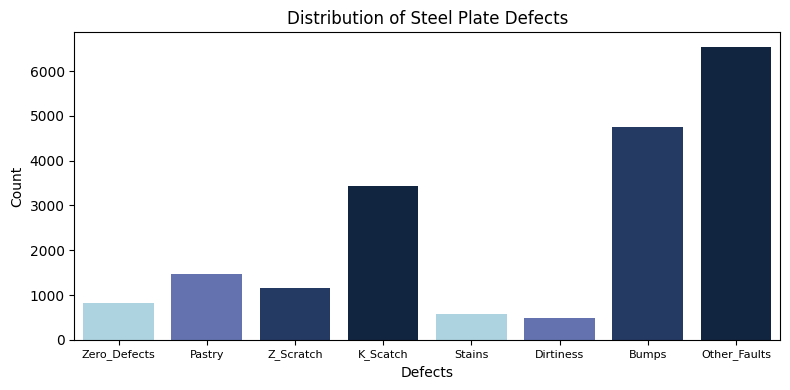

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
cmap_custom = ListedColormap(color_list)

plt.figure(figsize=(8, 4))
ax = sns.countplot(x=target, palette=color_list)
ax.set_xticklabels(target_classes) 

plt.title('Distribution of Steel Plate Defects')
plt.xlabel('Defects')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
plt.tight_layout() 
plt.show()

## 3.0 EDA and data preparation

Let's proceed to indeep explore and prepare the datasets (both the train and the test in parallel) for being suitable for modelling with both GLMs and Tree-based models.

Before starting, it is necessary to provide more information about the features.

The dataset "Steel Plates Faults" contains 27 features that describe each fault in detail. Here is an explanation of some of the features based on the information gathered from the search results:

1. **Location Features**:
   - X_Minimum: The minimum x-coordinate of the fault.
   - X_Maximum: The maximum x-coordinate of the fault.
   - Y_Minimum: The minimum y-coordinate of the fault.
   - Y_Maximum: The maximum y-coordinate of the fault.
   

2. **Size Features**:
   - Pixels_Areas: Area of the fault in pixels.
   - X_Perimeter: Perimeter along the x-axis of the fault.
   - Y_Perimeter: Perimeter along the y-axis of the fault.
   

3. **Luminosity Features**:
   - Sum_of_Luminosity: Sum of luminosity values in the fault area.
   - Minimum_of_Luminosity: Minimum luminosity value in the fault area.
   - Maximum_of_Luminosity: Maximum luminosity value in the fault area.
  

4. **Material and Index Features**:
   - TypeOfSteel_A300: Type of steel (A300).
   - TypeOfSteel_A400: Type of steel (A400).
   - Steel_Plate_Thickness: Thickness of the steel plate.
   - Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index: Various index values related to edges and geometry.


5. **Logarithmic Features**:
   - LogOfAreas: Logarithm of the area of the fault.
   - Log_X_Index, Log_Y_Index: Logarithmic indices related to X and Y coordinates.


6. **Statistical Features**:
   - Orientation_Index: Index describing orientation.
   - Luminosity_Index: Index related to luminosity.
   - SigmoidOfAreas: Sigmoid function applied to areas.

These features provide detailed information about each steel plate fault, including its location, size, material characteristics, geometric properties, and statistical attributes. Researchers and practitioners can utilize these features for classification tasks and automatic pattern recognition using machine learning algorithms.

### 3.1 Missing values

As found in litereture and in the original data, there are no missing cases.

In [13]:
train.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

### 3.2 Data Types and feature classification

Let's enumerate the numeric (continuous and ordinal) features fromt the categorical ones.

In [14]:
train.dtypes

X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
dtype: object

All the numeric features, have enough distinct values to confirm their are continuous ones

In [15]:
train.nunique()

X_Minimum                1191
X_Maximum                1259
Y_Minimum                3345
Y_Maximum                3341
Pixels_Areas             1154
X_Perimeter               460
Y_Perimeter               331
Sum_of_Luminosity        2595
Minimum_of_Luminosity     162
Maximum_of_Luminosity      98
Length_of_Conveyer         99
TypeOfSteel_A300            2
TypeOfSteel_A400            2
Steel_Plate_Thickness      27
Edges_Index              1849
Empty_Index              1748
Square_Index             1118
Outside_X_Index           525
Edges_X_Index            1102
Edges_Y_Index             900
Outside_Global_Index        4
LogOfAreas               1072
Log_X_Index               206
Log_Y_Index               241
Orientation_Index        1598
Luminosity_Index         2046
SigmoidOfAreas            467
dtype: int64

We directly check TypeOfSteel_A300, TypeOfSteel_A400, which we presume binary, and Steel_Plate_Thickness which should be ordinal.

In [16]:
train.TypeOfSteel_A300.value_counts()

TypeOfSteel_A300
0    11480
1     7739
Name: count, dtype: int64

In [17]:
train.TypeOfSteel_A400.value_counts()

TypeOfSteel_A400
1    11461
0     7758
Name: count, dtype: int64

In [18]:
train.Steel_Plate_Thickness.value_counts()

Steel_Plate_Thickness
40     7625
70     3703
80     1661
100    1433
50     1011
60      856
200     748
300     434
175     396
69      283
90      211
150     191
120     164
143     138
185     116
220     105
130      44
125      24
85       21
211      18
290      11
140       8
250       8
180       7
159       1
81        1
86        1
Name: count, dtype: int64

Steel_Plate_Thickness is certainly ordinal but also numeric, that is a discretized numeric feature. We can just treat it as a numeric.

In [19]:
train.Outside_Global_Index.value_counts()

Outside_Global_Index
1.0    11022
0.0     7490
0.5      706
0.7        1
Name: count, dtype: int64

Outside_Global_Index is indeed a bizzare feature: it seems a binary but it has some intermediate values that we leave alone for the moment.

### 3.3 Distribution pairs

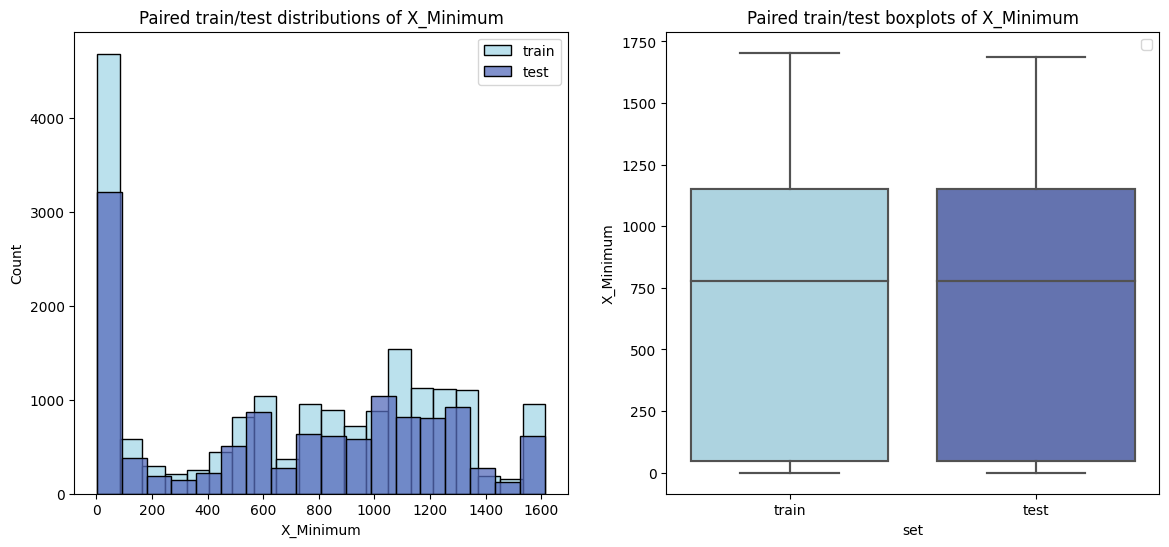

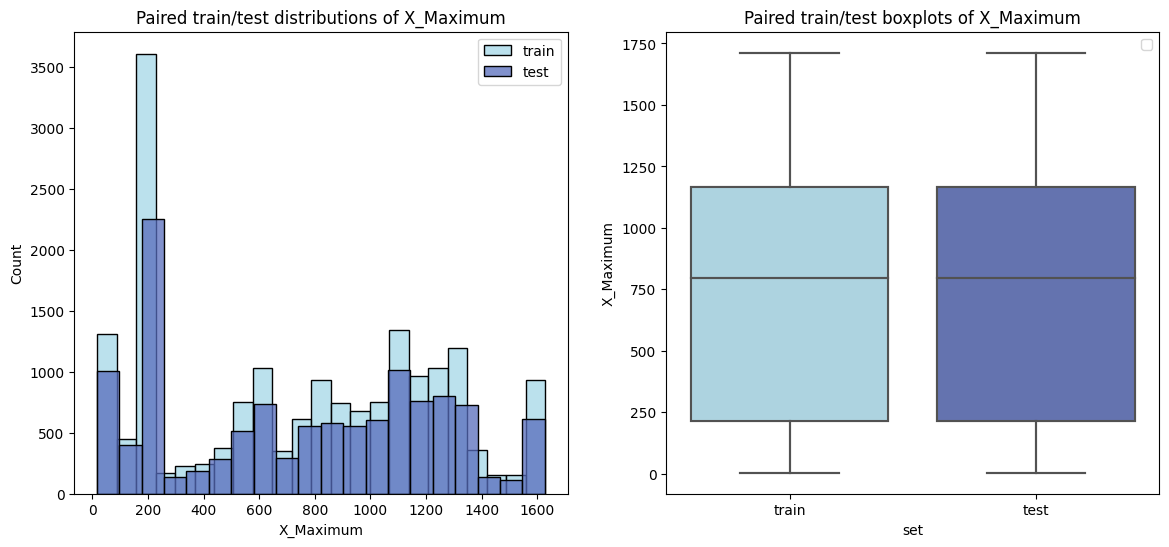

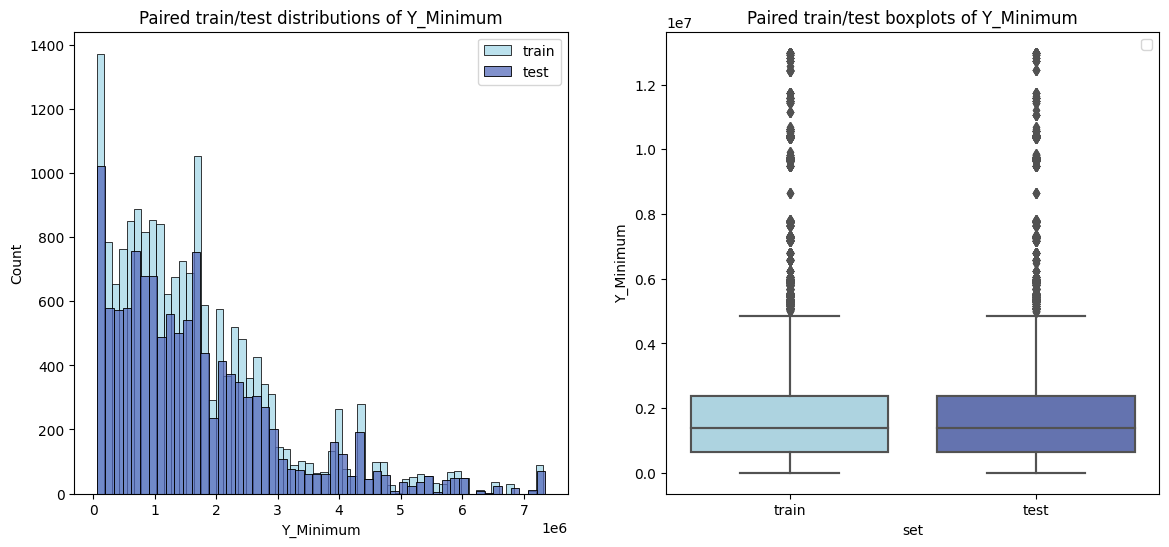

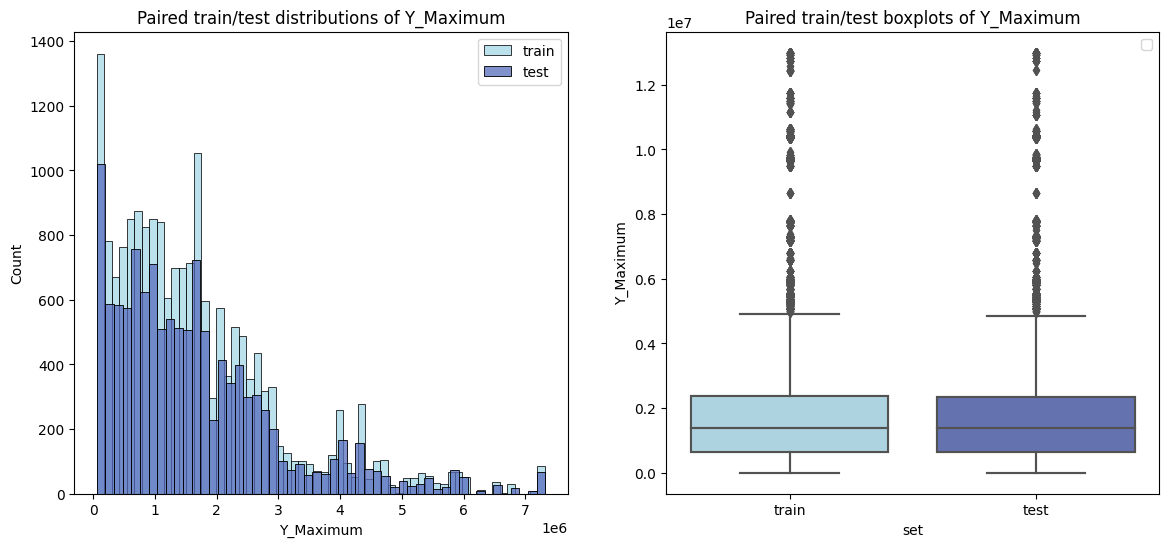

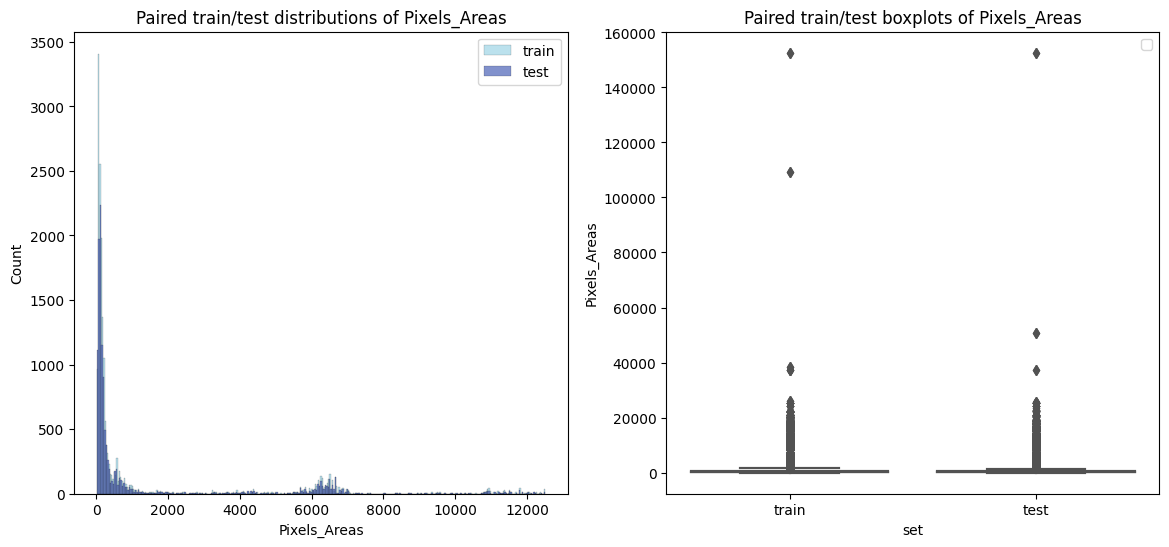

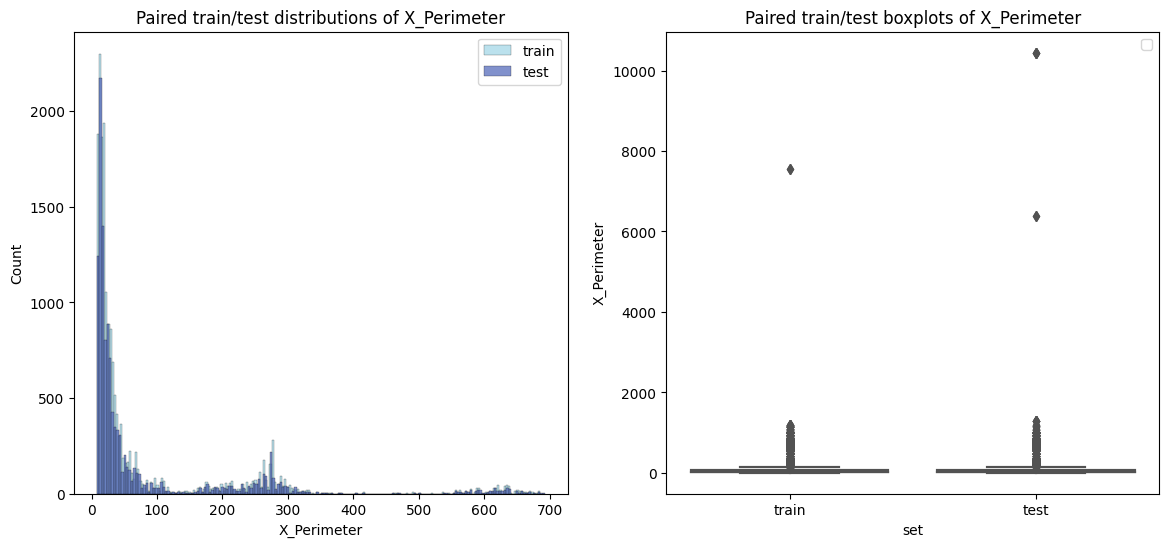

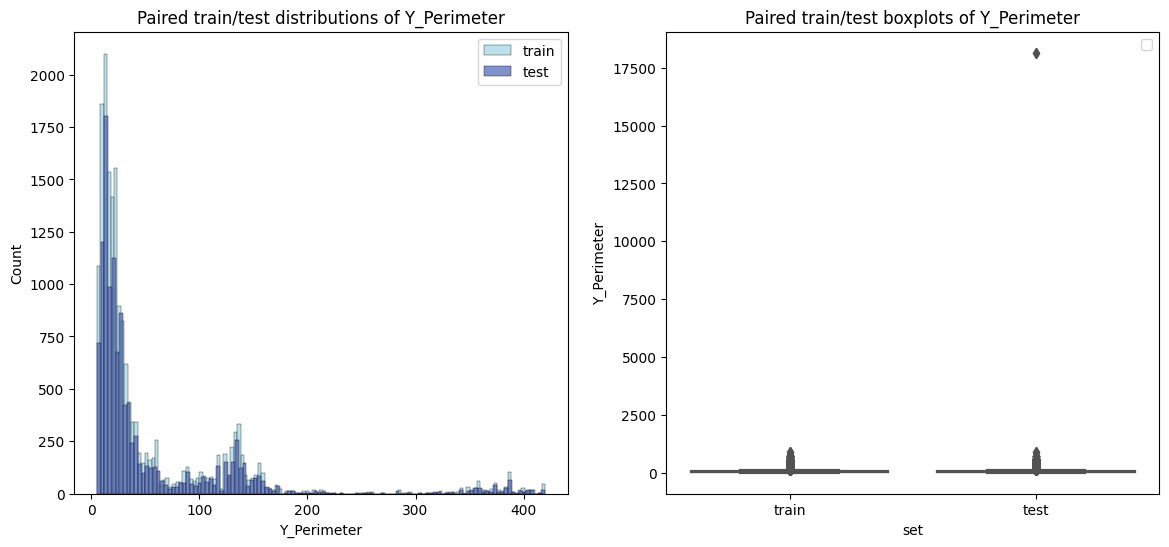

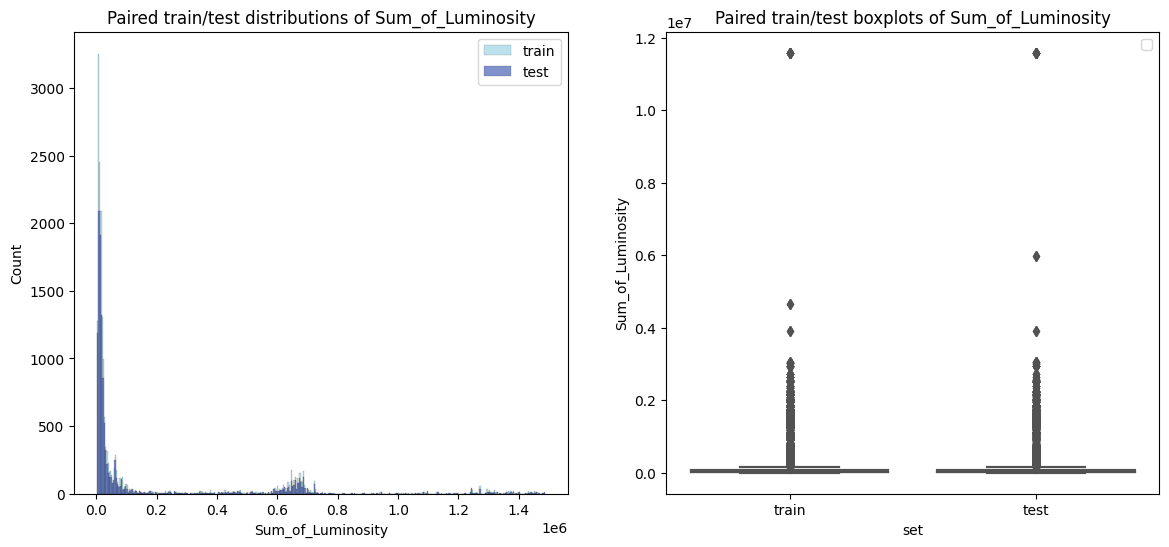

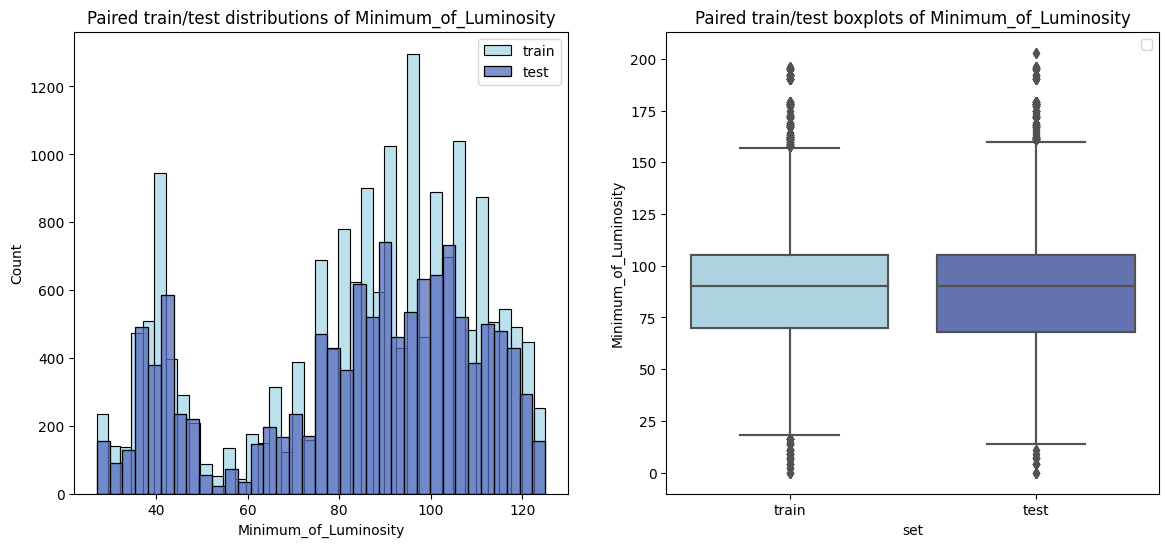

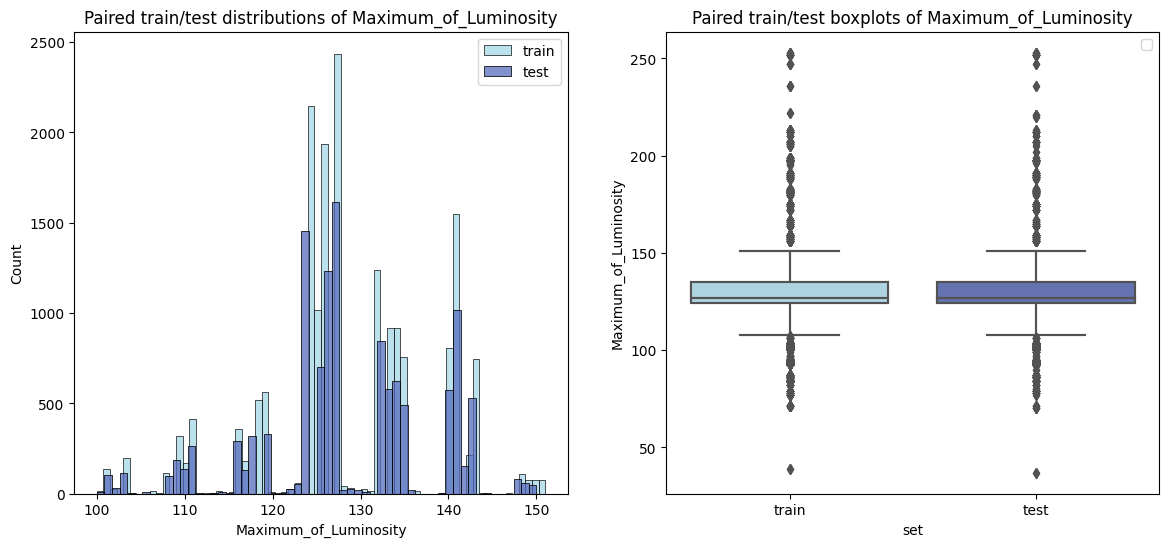

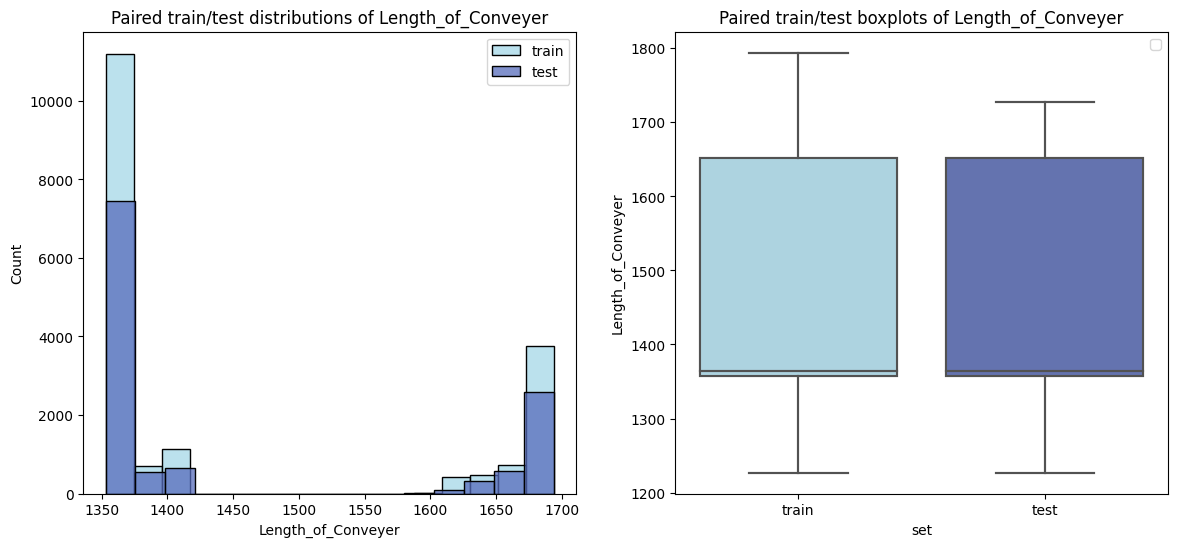

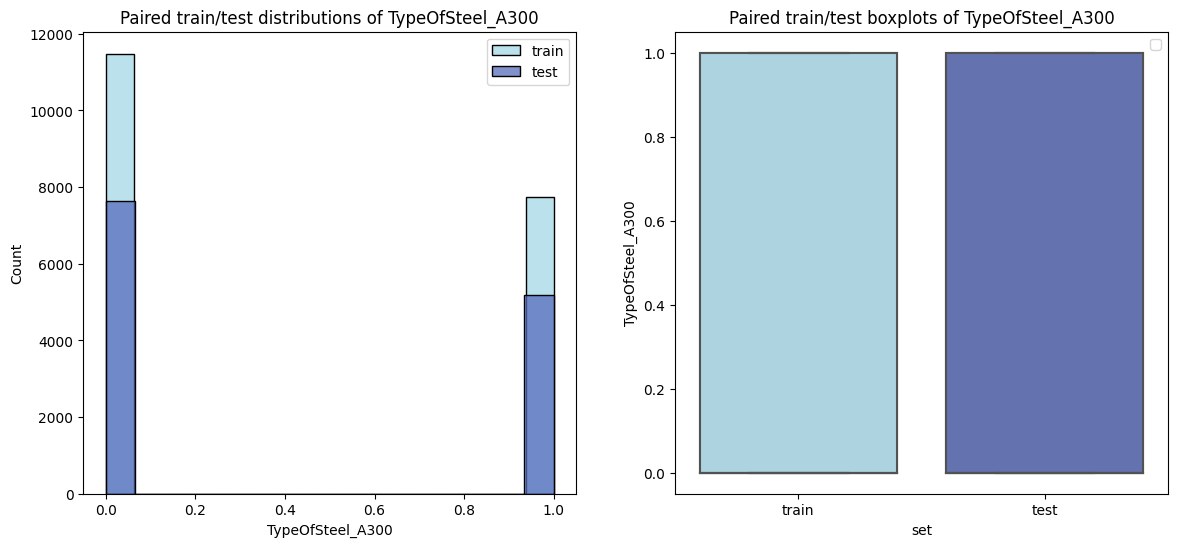

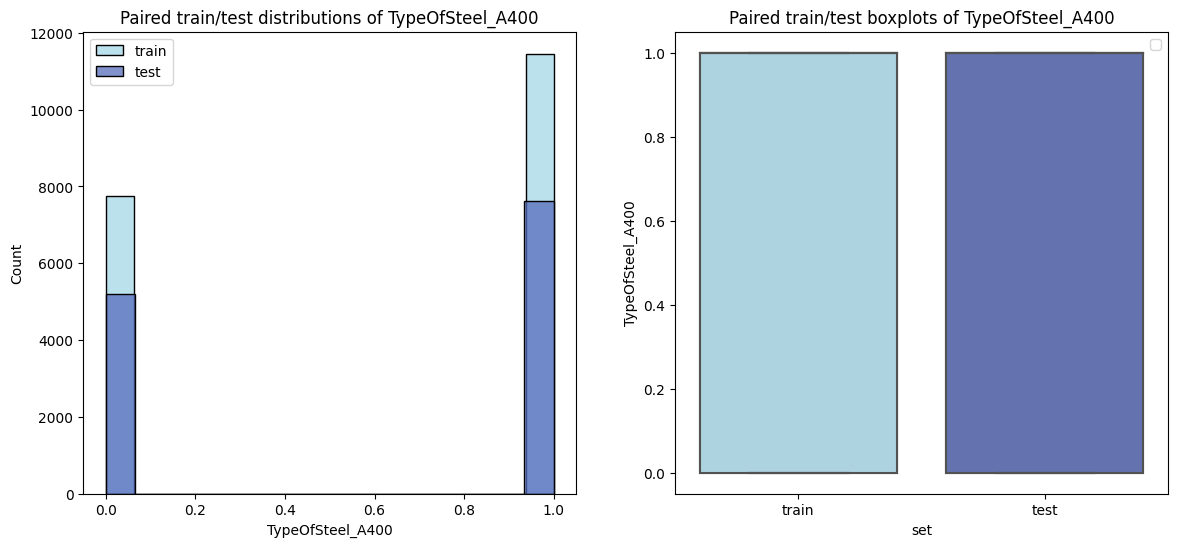

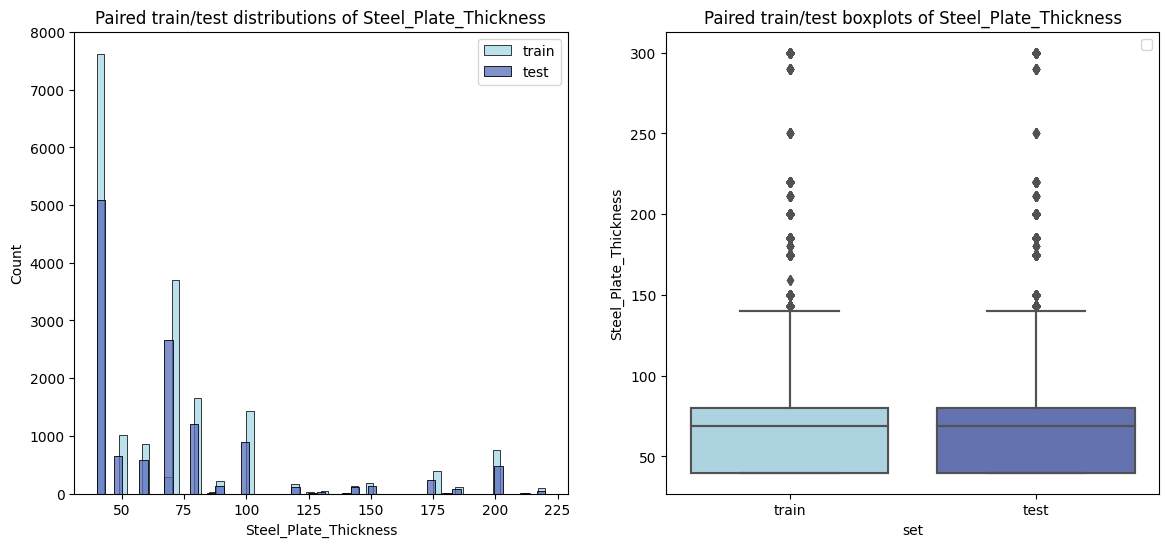

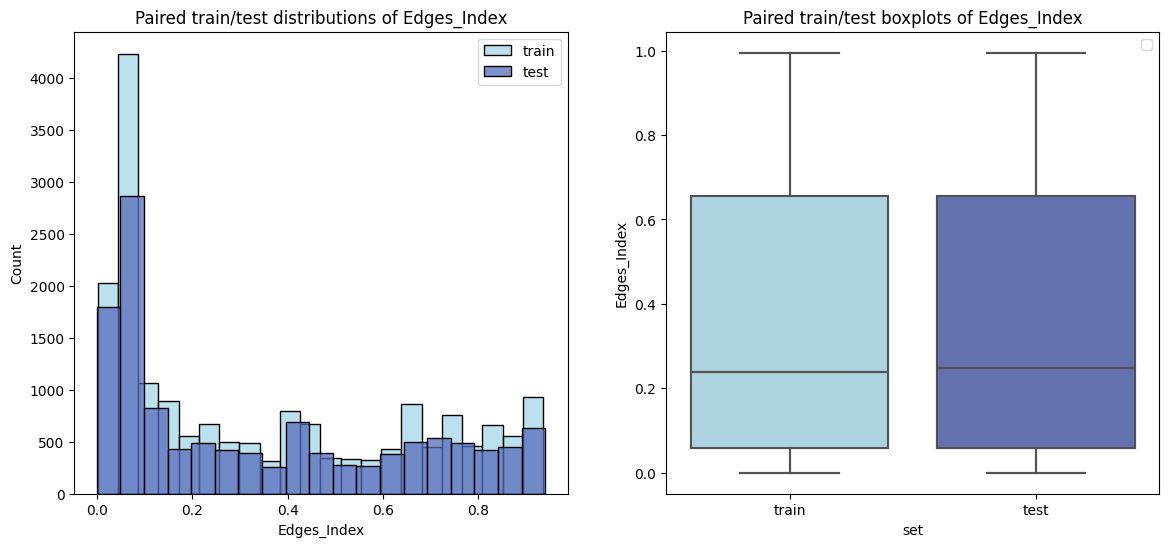

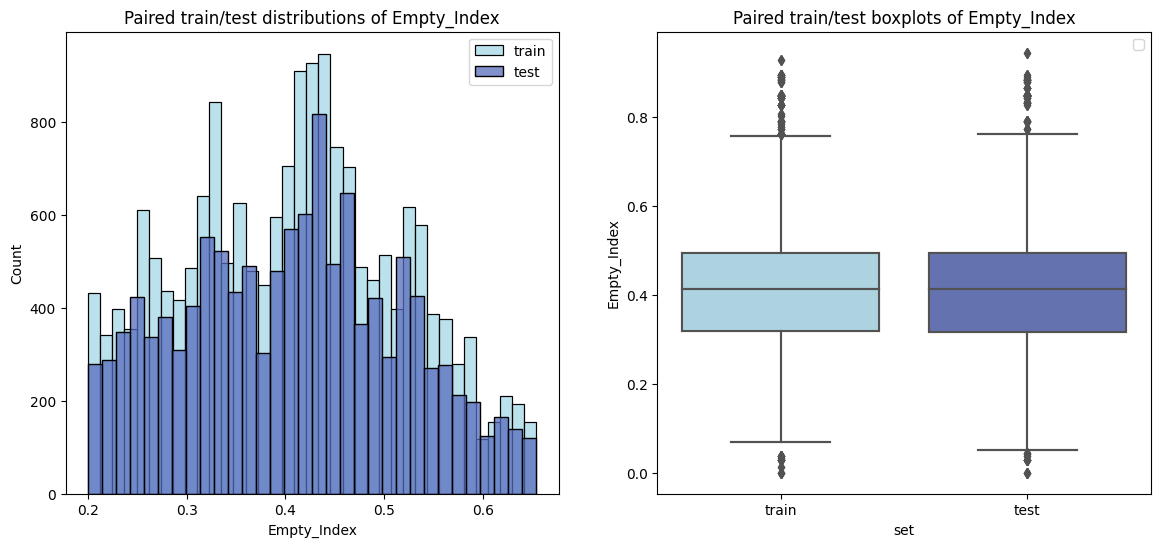

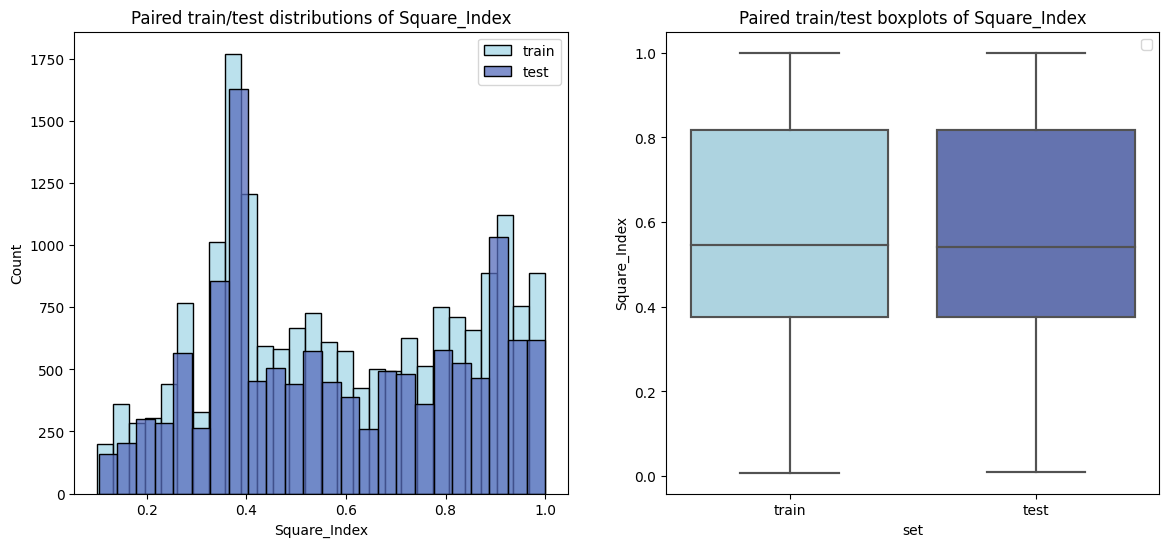

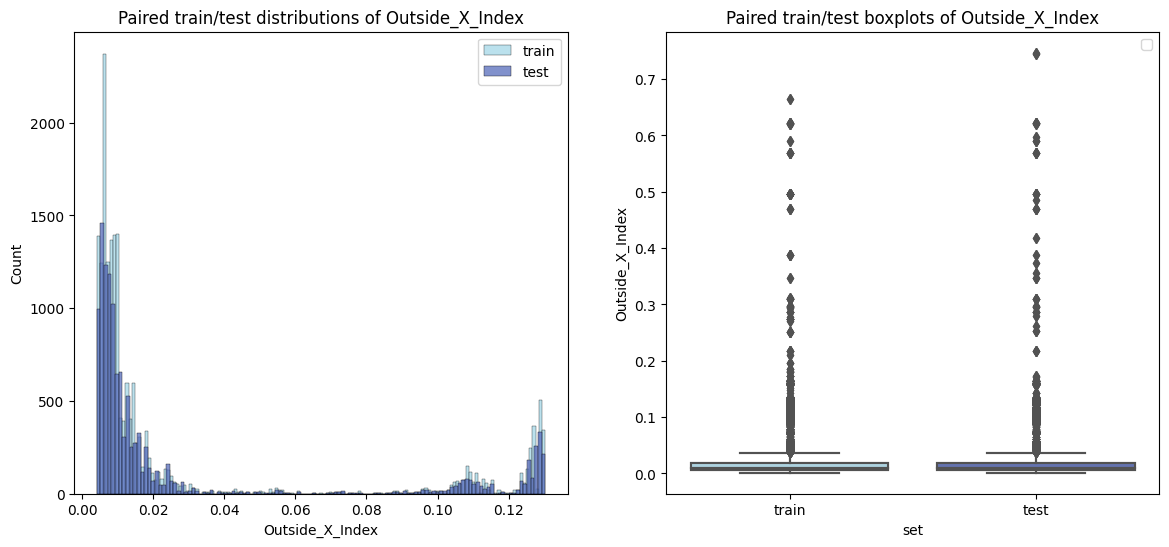

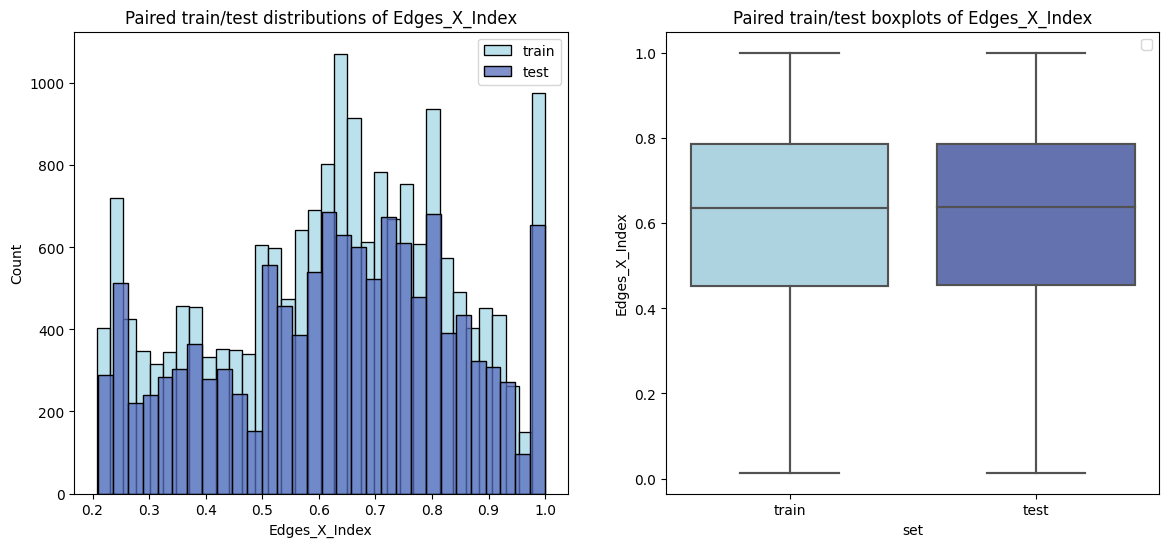

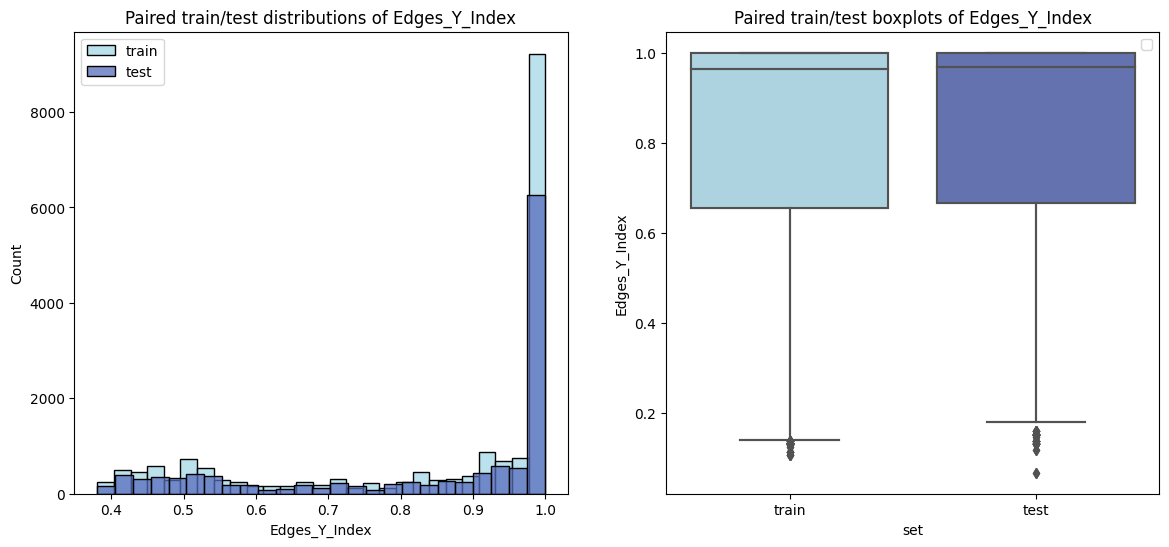

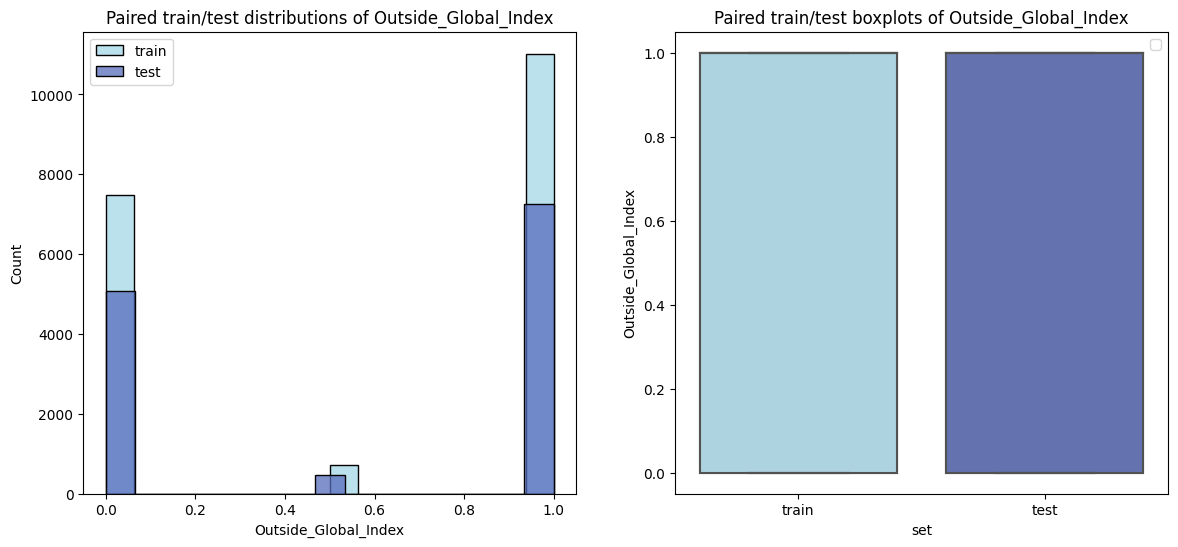

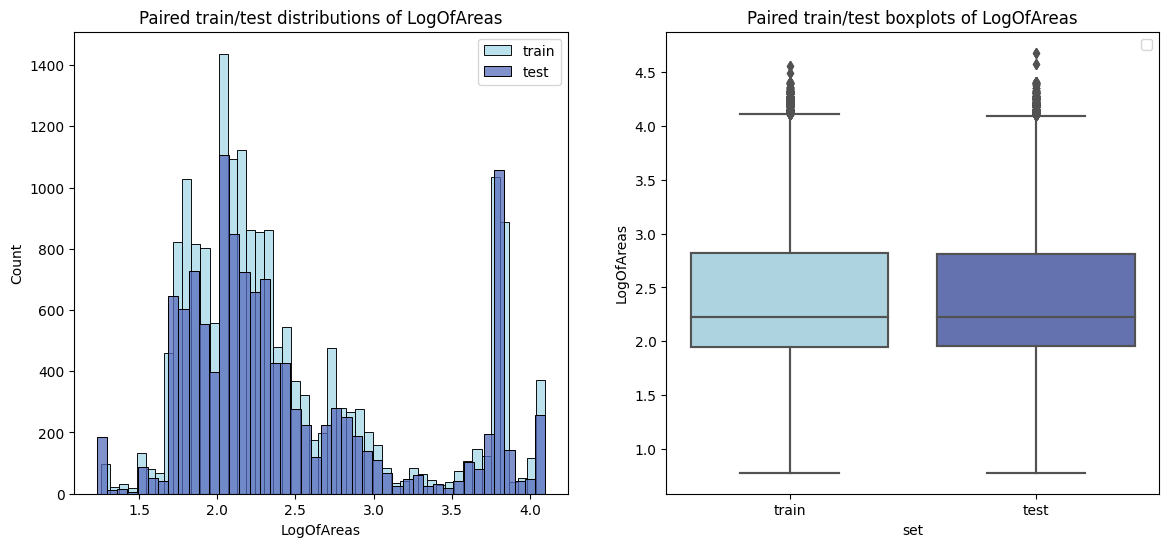

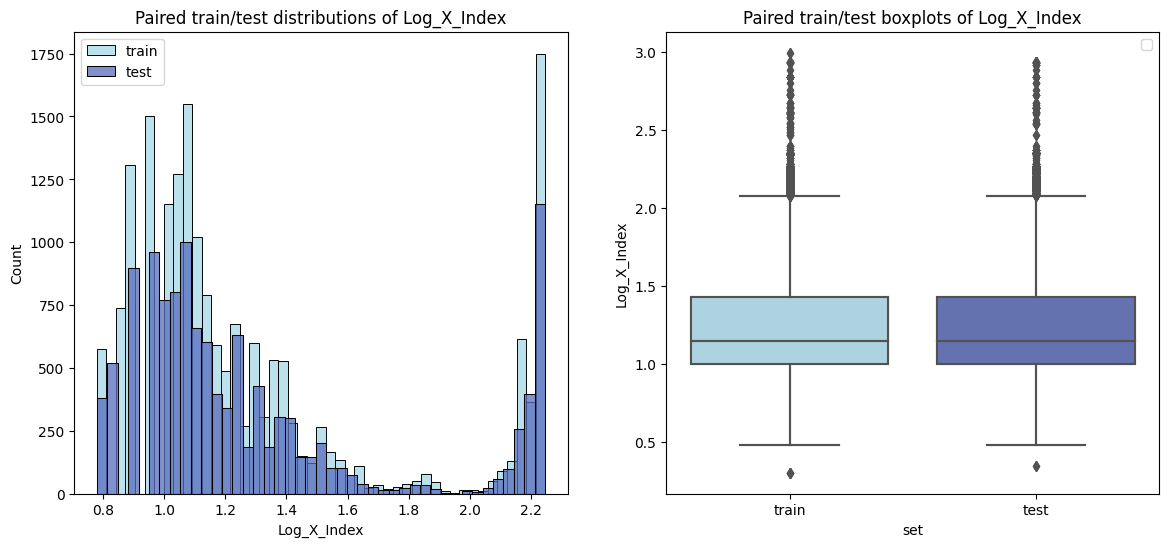

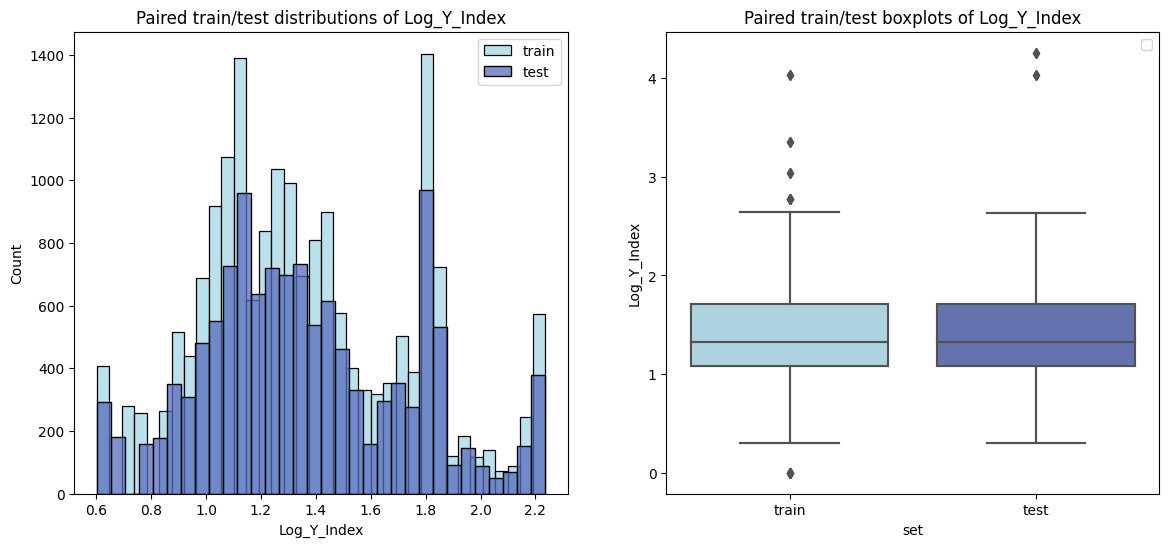

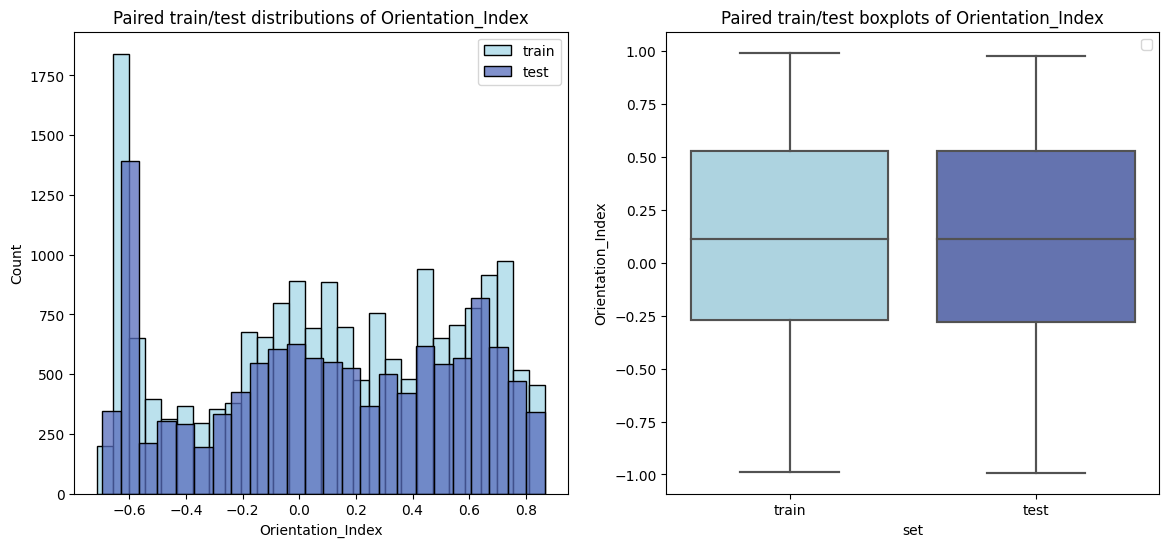

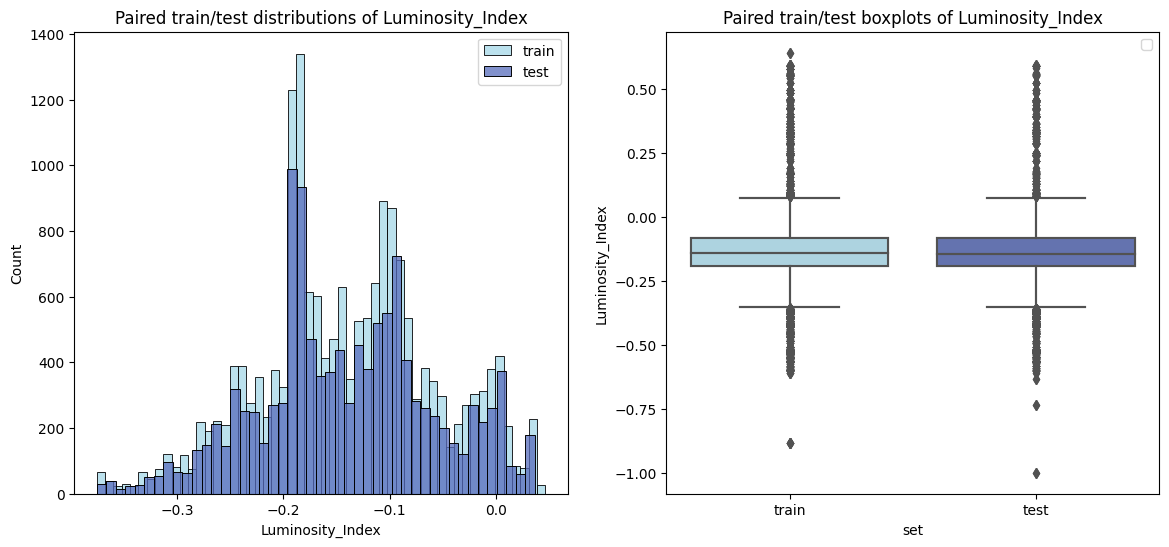

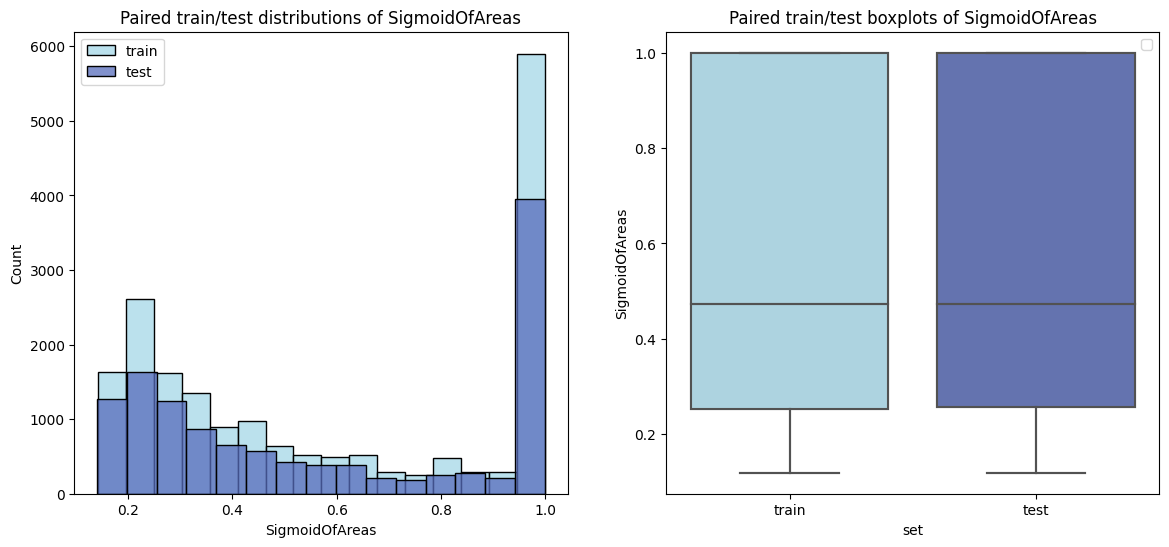

In [20]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

    
for feature in train.columns:
    plot_distribution_pairs(train, test, feature, palette=color_list)

### 3.6 Adversarial validation

We take the code for adversarial validation from the Kaggle Book: https://github.com/PacktPublishing/The-Kaggle-Book/blob/main/chapter_06/adversarial-validation-example.ipynb

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

X =  pd.concat([train, test], axis=0)
y = [0] * len(train) + [1] * len(test)

model = RandomForestClassifier(random_state=0)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.496


Since the roc-auc score is about 0.5, we have a confirmation that train and test are from the same distribution.

### 3.7 Feature engineering

At this point we try to create some smart feature engineering. We operate the transformations on the train and test set.

Coordinate Range Features: By calculating the range of coordinates (both in the x and y directions), we capture information about the spatial extent of each fault. This could be relevant because faults with larger spatial extents might indicate more severe defects or anomalies in the steel plate

In [22]:
def calculate_coordinate_range_features(data):
    data['X_Range'] = (data['X_Maximum'] - data['X_Minimum'])
    data['Y_Range'] =( data['Y_Maximum'] - data['Y_Minimum'])
    return data

train = calculate_coordinate_range_features(train)
test = calculate_coordinate_range_features(test)

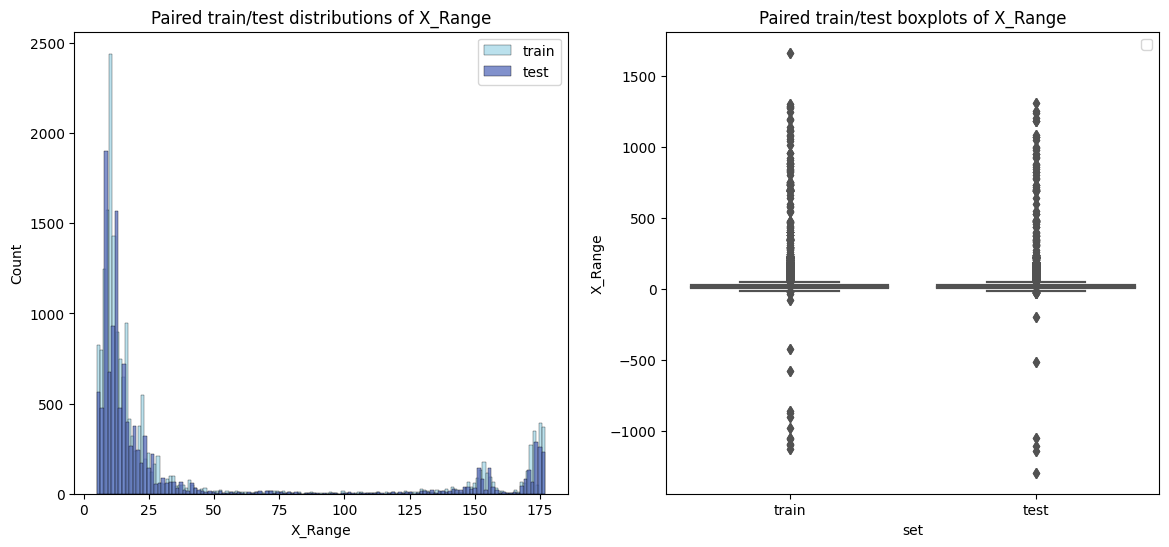

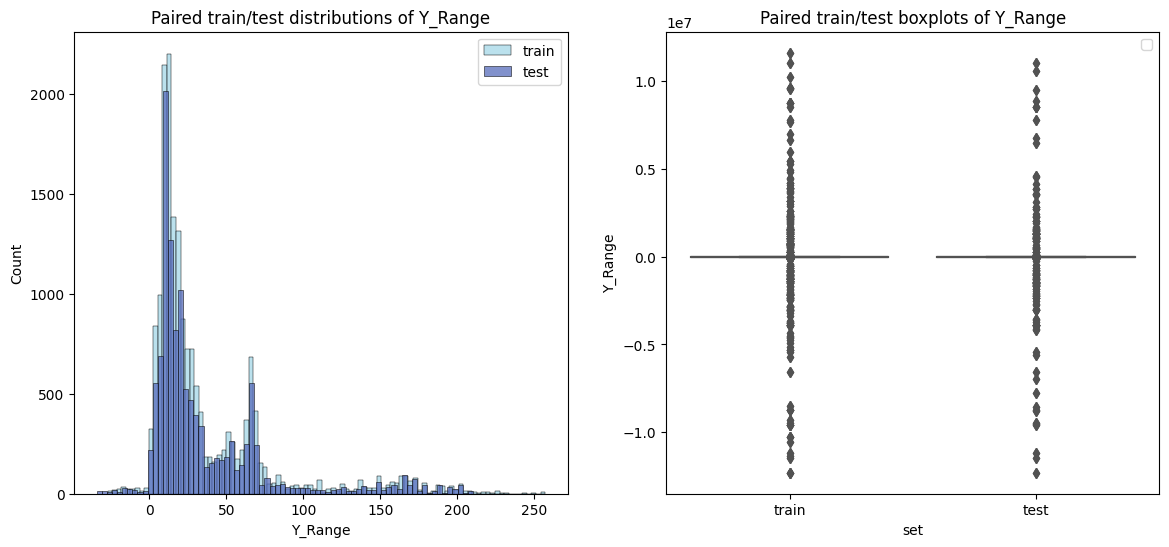

In [23]:
plot_distribution_pairs(train, test, feature="X_Range", palette=color_list)
plot_distribution_pairs(train, test, feature="Y_Range", palette=color_list)

Size Ratio Features: The ratio of area to perimeter provides insight into the compactness or irregularity of each fault. Faults with higher area-to-perimeter ratios could be more irregular in shape, potentially indicating complex defects that require closer inspection.

In [24]:
def calculate_size_ratio_features(data):
    data['Area_Perimeter_Ratio'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])
    return data

train = calculate_size_ratio_features(train)
test = calculate_size_ratio_features(test)

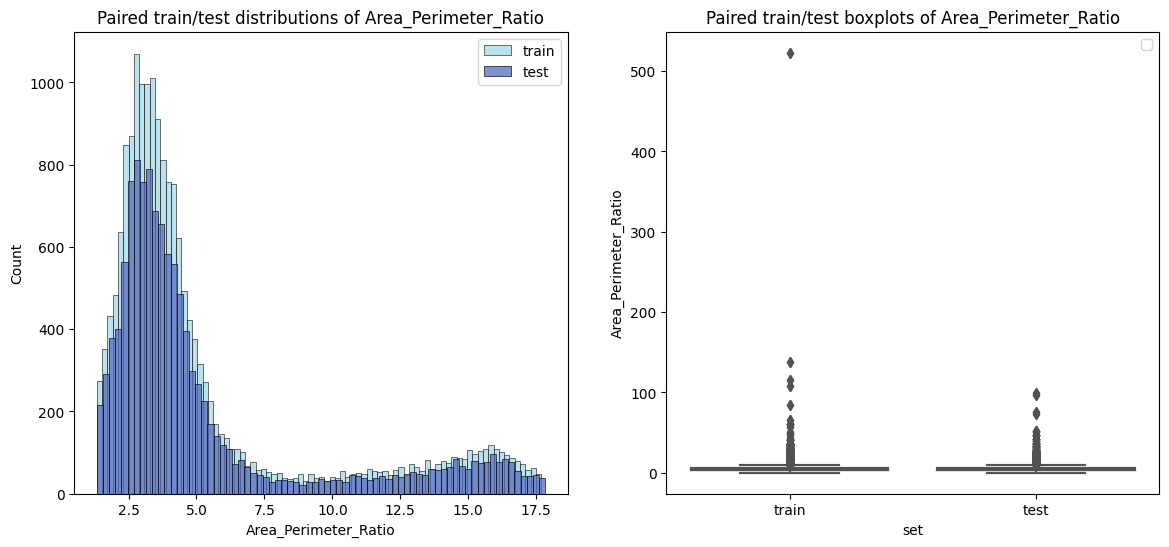

In [25]:
plot_distribution_pairs(train, test, feature="Area_Perimeter_Ratio", palette=color_list)

Luminosity Range Feature: The range of luminosity values within a fault area can indicate variations in brightness or darkness, which might be associated with different types or severities of defects. For example, larger luminosity ranges could suggest areas with contrasting levels of brightness, potentially highlighting regions with significant defects.

In [26]:
def calculate_luminosity_range_feature(data):
    data['Luminosity_Range'] = (data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity'])
    return data

train = calculate_luminosity_range_feature(train)
test = calculate_luminosity_range_feature(test)

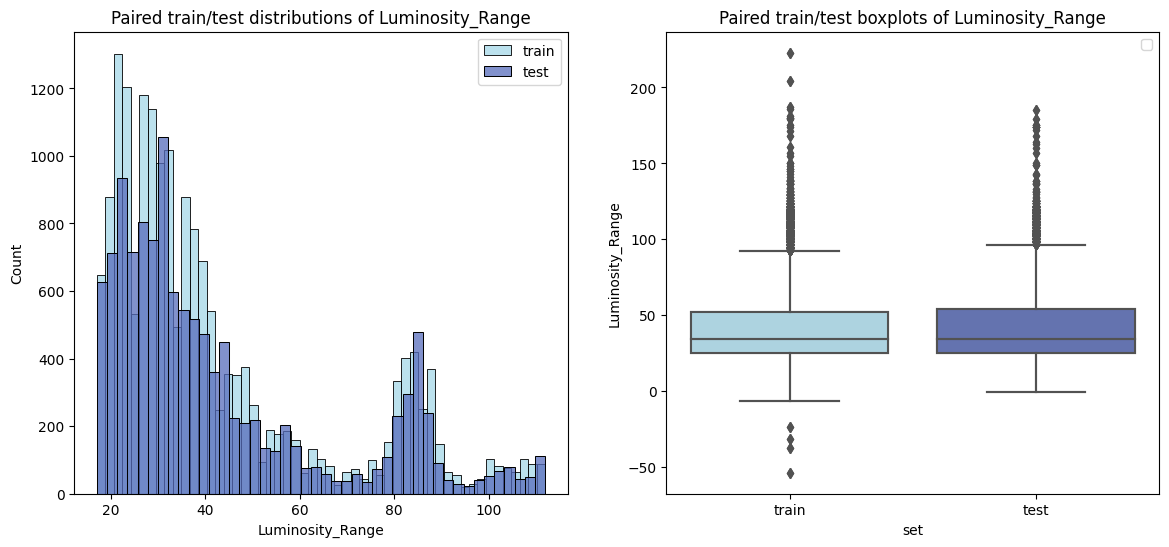

In [27]:
plot_distribution_pairs(train, test, feature="Luminosity_Range", palette=color_list)

As a last step, before proceeding to modelling, let's save all the data to disk for reusing it with models different from XGBoost (useful for a blending or stacking, later).

In [28]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [29]:
pd.Series(target, name="target").to_csv("target.csv")

# 4.0 Modelling

For speeding up things, since we are going to work with GPUs, we rescale the features in the range 0-1. Operating on smaller float numbers, ml algorithms should speed up. We maintain as much as we can the float64 datatype because the reduction to float32 may result in rounding differences (see: https://www.kaggle.com/lucamassaron/normalization-vs-standardization/)

In [30]:
from sklearn.preprocessing import MinMaxScaler

train = train.astype(np.float64)
test = test.astype(np.float64)

mmscaler = MinMaxScaler()

mmscaler.fit(train)

train[:] = mmscaler.transform(train)
test[:] = mmscaler.transform(test)

The presence of unequally distributed target classes requires us to stratify our model when cosidering the cross validation strategy

In [31]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(train, y=target)

In [32]:
list(cv_splits)

[(array([    0,     2,     3, ..., 19216, 19217, 19218]),
  array([    1,     9,    23, ..., 19196, 19201, 19213])),
 (array([    0,     1,     2, ..., 19215, 19216, 19218]),
  array([    7,     8,    20, ..., 19194, 19195, 19217])),
 (array([    0,     1,     2, ..., 19216, 19217, 19218]),
  array([    3,    10,    11, ..., 19205, 19211, 19215])),
 (array([    0,     1,     2, ..., 19214, 19215, 19217]),
  array([    5,     6,    18, ..., 19209, 19216, 19218])),
 (array([    1,     3,     5, ..., 19216, 19217, 19218]),
  array([    0,     2,     4, ..., 19210, 19212, 19214]))]

### 4.1 First temptative models (hand tuning)

We first try a simple XGBoost model, having care to estimate cv predictions and metrics

In [33]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier

cv_splits = cv.split(train, y=target)
roc_auc_scores = list()
cv_oof = pd.DataFrame(np.zeros((len(target), len(target_classes))), columns=target_classes)

for train_idx, val_idx in cv_splits:
    
    xgb = XGBClassifier(booster='gbtree',
                        device = "cuda",
                        tree_method="hist",
                        objective='multi:softmax',  # 'multi:softmax' or 'multi:softprob' for multiclass classification
                        num_class=len(set(target)),  # Number of classes
                        n_estimators=300,
                        max_depth=6,
                        verbosity=0)

    X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]
    
    xgb.fit(X_train_fold, y_train_fold)
    
    y_val_prob = xgb.predict_proba(X_val_fold)
    # We compute the validation score on the original multilabel targets
    roc_auc = roc_auc_score(targets_bin.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr')
    
    cv_oof.iloc[val_idx, :] = y_val_prob
    
    roc_auc_scores.append(roc_auc)

# Calculate the ROC AUC score statistics across all folds
roc_auc_mean = np.mean(roc_auc_scores)
roc_auc_std = np.std(roc_auc_scores)
roc_auc_max = np.max(roc_auc_scores)
roc_auc_min = np.min(roc_auc_scores)

print(f'Cross-validated ROC-AUC score: {roc_auc_mean:.3f} +/- {roc_auc_std:.3f}')
print(f'Max ROC-AUC score: {roc_auc_max:.3f}')
print(f'Min ROC-AUC score: {roc_auc_min:.3f}')

Cross-validated ROC-AUC score: 0.872 +/- 0.003
Max ROC-AUC score: 0.876
Min ROC-AUC score: 0.868


### 4.2 Error analysis

The error analysis is a key step to understand if your model is fitting the data and what are the core problems. Here we don't need anything fancy but a classification report and a confusion matrix. From the inspection of these two tools applied to the cv oof predictions, we can state that:

1. the zero defects class is not predictable at all, and since it seems random, probably it is a random error across all defect class. Probably we shouldn't worry predicting such class and just erase all the cases with no defect. They are a random glitch that at best won't affect our model.

2. The hardest classes to predict are Pastry and Dirtiness. In particular, it is important to notice that:
    * Pastry and Bumps are often confused
    * Dirtiness and Bumps are often confused
    * Pastry, bumps and dirtiness are often confused with other faults

Solving the problems that the error analysis points out, definitely means improving the model. The best way for doing so is feature engineering, IMHO.

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true=target, 
                            y_pred=np.argmax(cv_oof, axis=1), 
                            target_names=target_classes))

              precision    recall  f1-score   support

Zero_Defects       0.10      0.01      0.01       818
      Pastry       0.37      0.20      0.26      1465
   Z_Scratch       0.61      0.58      0.60      1150
    K_Scatch       0.88      0.90      0.89      3432
      Stains       0.70      0.79      0.75       568
   Dirtiness       0.39      0.15      0.22       485
       Bumps       0.48      0.49      0.49      4761
Other_Faults       0.46      0.58      0.51      6540

    accuracy                           0.56     19219
   macro avg       0.50      0.46      0.47     19219
weighted avg       0.53      0.56      0.54     19219



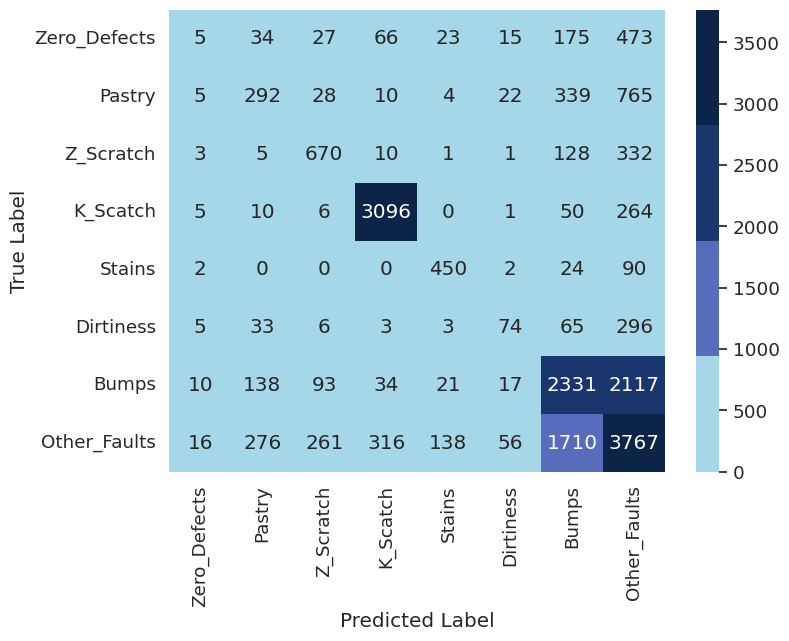

In [35]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=target, 
                               y_pred=np.argmax(cv_oof, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom, 
            xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 4.3 Model optimization by Optuna and Bayesian search

As a next step we optimize XGBoost most important hyper-parameters using a bayesian search by Optuna. The TPESampler is set to first try random optimization for the first 30 trials and then perform a TPE Bayesian Search. We also use the multivariate approach (added in v2.2.0 as an experimental feature), which is reported to outperform the independent TPE.

In [36]:
import optuna
from optuna.samplers import TPESampler

# Activate optuna search by setting run_optimization to True
run_optimization = False

def objective(trial):
    
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        
    }
    
    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "hist"
    

    cv_splits = cv.split(train, y=target)
    cv_scores = list()
    
    for train_idx, val_idx in cv_splits:
    
        xgb = XGBClassifier(**params)

        X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
        y_train_fold, y_val_fold = target[train_idx], target[val_idx]

        xgb.fit(X_train_fold, y_train_fold)

        y_val_prob = xgb.predict_proba(X_val_fold)
        cv_scores.append(roc_auc_score(targets_bin.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr'))

    cv_evaluation = np.mean(cv_scores)
    
    return cv_evaluation

if run_optimization:
    
    sqlite_db = "sqlite:///sqlite.db"
    study_name = "multi_class_prediction_of_obesity_risk"
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    best_cls_params = study.best_params
    best_value = study.best_value

else:
    
    best_value = 0.88887
    best_cls_params = {'grow_policy': 'depthwise', 
                       'n_estimators': 785, 
                       'learning_rate': 0.020726270353596147, 
                       'gamma': 0.13894214878891328, 
                       'subsample': 0.6931112900708679, 
                       'colsample_bytree': 0.5210477365658035, 
                       'max_depth': 3, 
                       'min_child_weight': 2, 
                       'reg_lambda': 5.369876648869387e-06, 
                       'reg_alpha': 8.428323563897863e-09}

print(f"best optmized accuracy: {best_value:0.5f}")
print(f"best hyperparameters: {best_cls_params}")

best_cls_params['objective'] = 'multi:softmax'
best_cls_params['tree_method'] = "hist"
best_cls_params["device"] = "cuda"
best_cls_params["verbosity"] = 0

best optmized accuracy: 0.88887
best hyperparameters: {'grow_policy': 'depthwise', 'n_estimators': 785, 'learning_rate': 0.020726270353596147, 'gamma': 0.13894214878891328, 'subsample': 0.6931112900708679, 'colsample_bytree': 0.5210477365658035, 'max_depth': 3, 'min_child_weight': 2, 'reg_lambda': 5.369876648869387e-06, 'reg_alpha': 8.428323563897863e-09}


### 4.4 Re-train on all data

In [37]:
from xgboost import XGBClassifier

xgb = xgb = XGBClassifier(**best_cls_params)
xgb.fit(train, target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5210477365658035, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.13894214878891328,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.020726270353596147,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=785, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

# 5.0 Explainability

To understand how the model actually works, the XGBoost model itself, represented by the booster, is used to calculate SHAP (SHapley Additive exPlanations) values for each feature in the training data. The feature names are extracted from the 'train' DataFrame, and a DMatrix 'Xd' is created to represent the training data in a format suitable for XGBoost. The SHAP values are obtained by predicting contributions to the predictions using the 'predict' method with 'pred_contribs=True'.

In [38]:
from xgboost import DMatrix

booster = xgb.get_booster()

feature_names = train.columns
Xd = DMatrix(train)

shap_values = booster.predict(Xd, pred_contribs=True)
preds = booster.predict(Xd)

then we create a summary plot visualizing the impact of different features on the model predictions. The shap.summary_plot function is employed to generate a violin plot, where each violin represents the distribution of SHAP values for a specific feature.


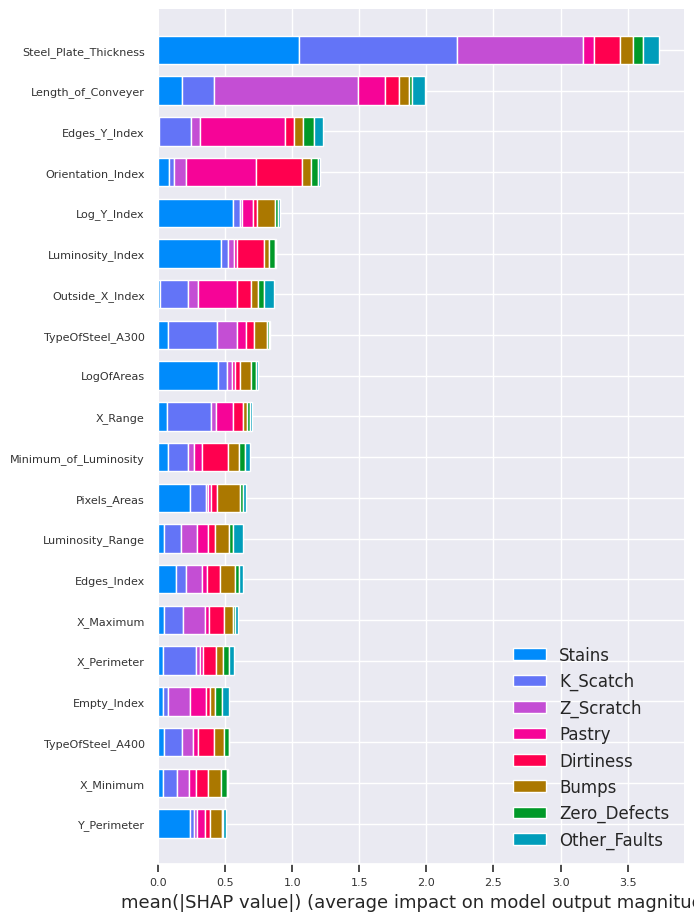

In [39]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(
    [shap_values[:, k, :-1] for k in range(shap_values.shape[1])],
    train.values, 
    plot_type="bar",
    feature_names=feature_names,
    class_names=target_classes,
    show=False,
)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()
print()

VIOLIN PLOT REPRESENTING <Zero_Defects>


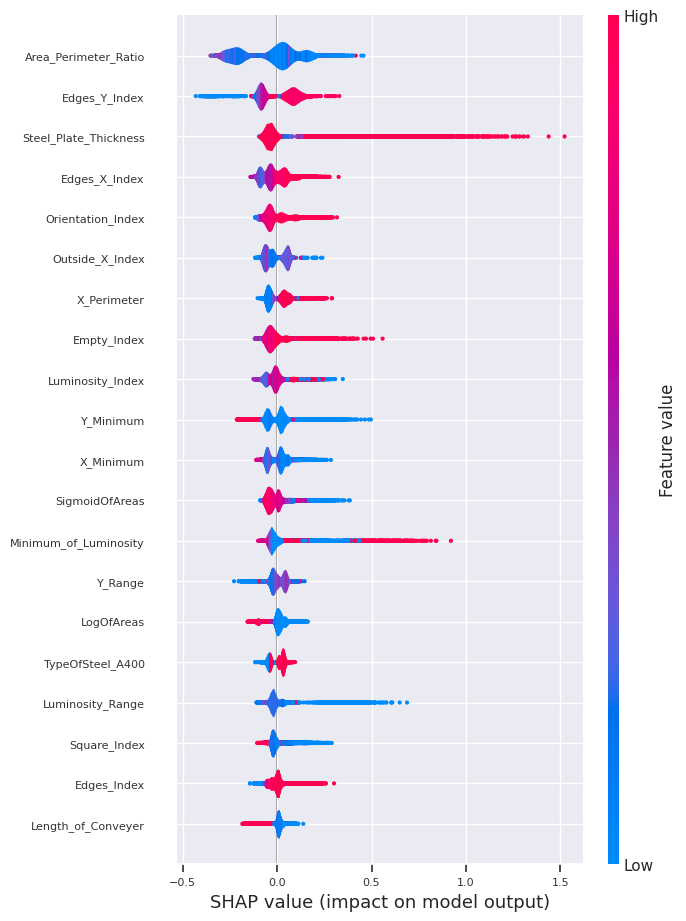


VIOLIN PLOT REPRESENTING <Pastry>


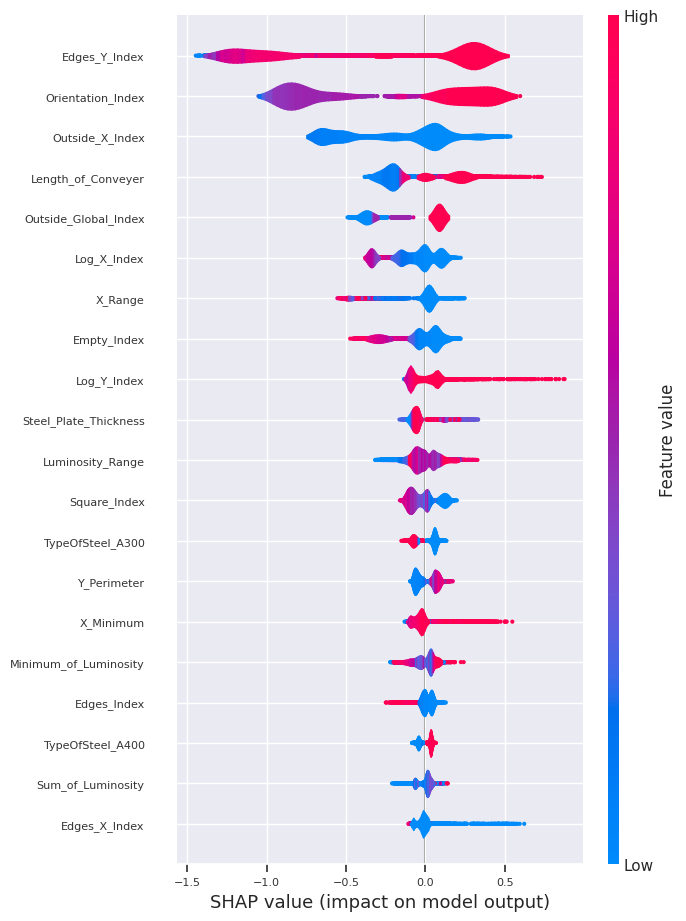


VIOLIN PLOT REPRESENTING <Z_Scratch>


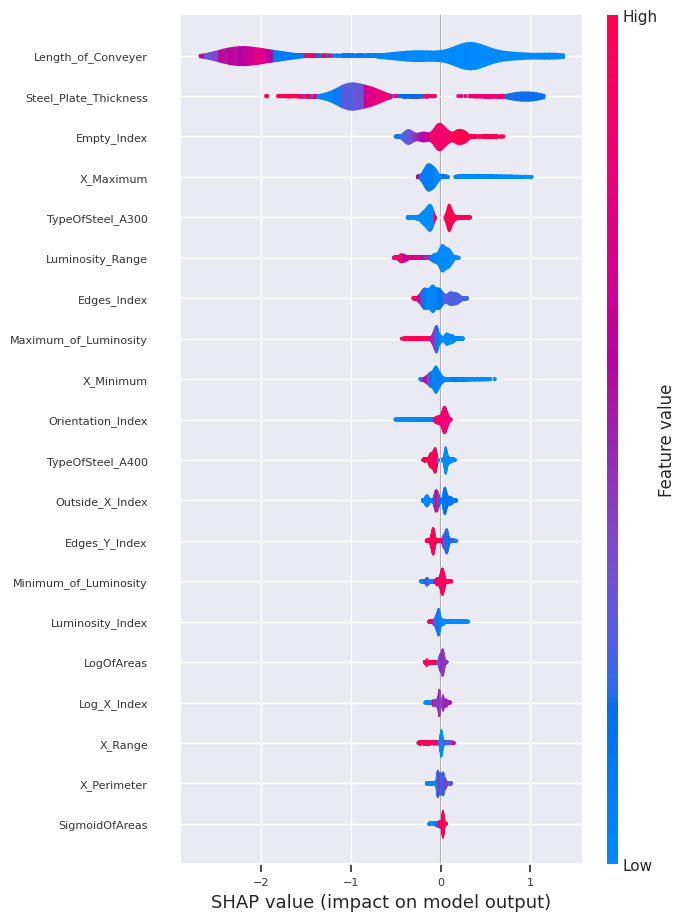


VIOLIN PLOT REPRESENTING <K_Scatch>


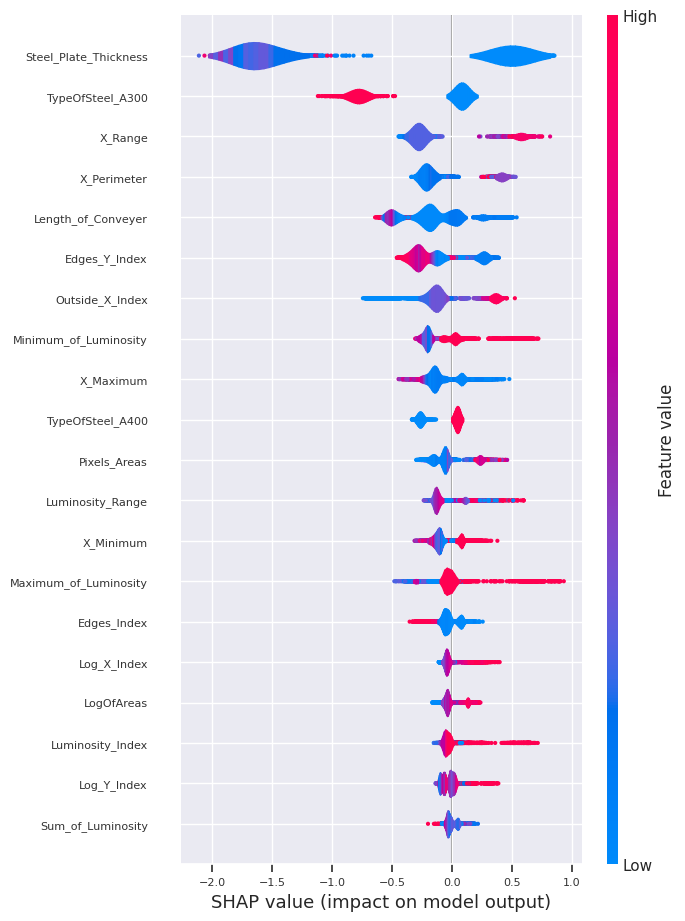


VIOLIN PLOT REPRESENTING <Stains>


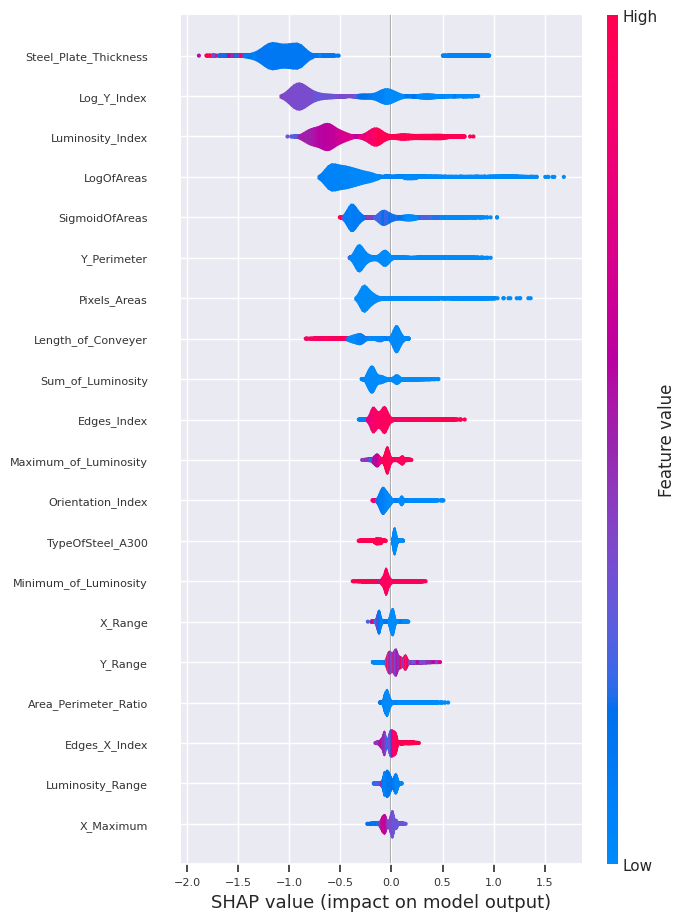


VIOLIN PLOT REPRESENTING <Dirtiness>


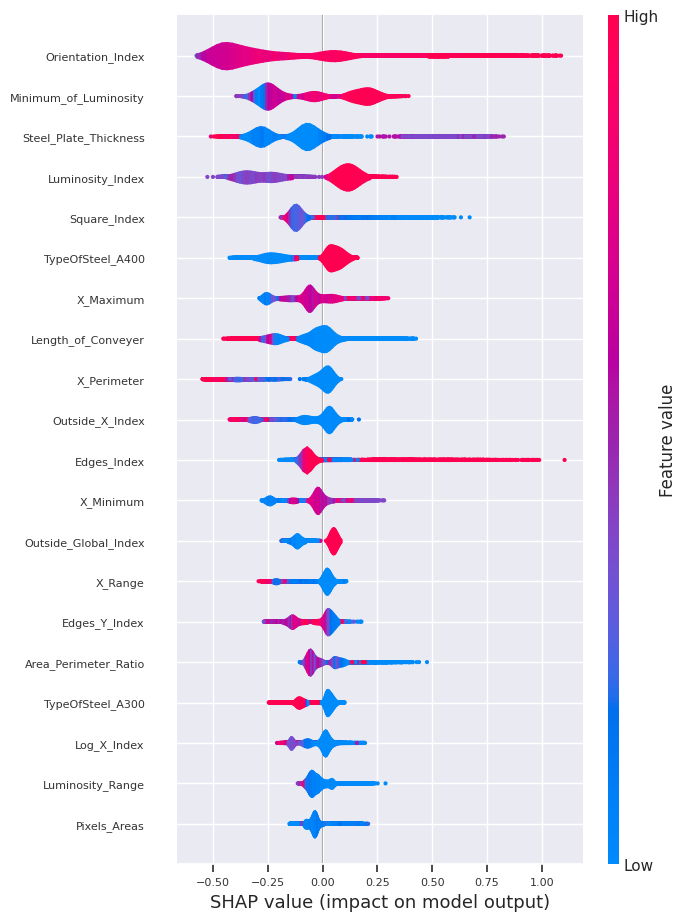


VIOLIN PLOT REPRESENTING <Bumps>


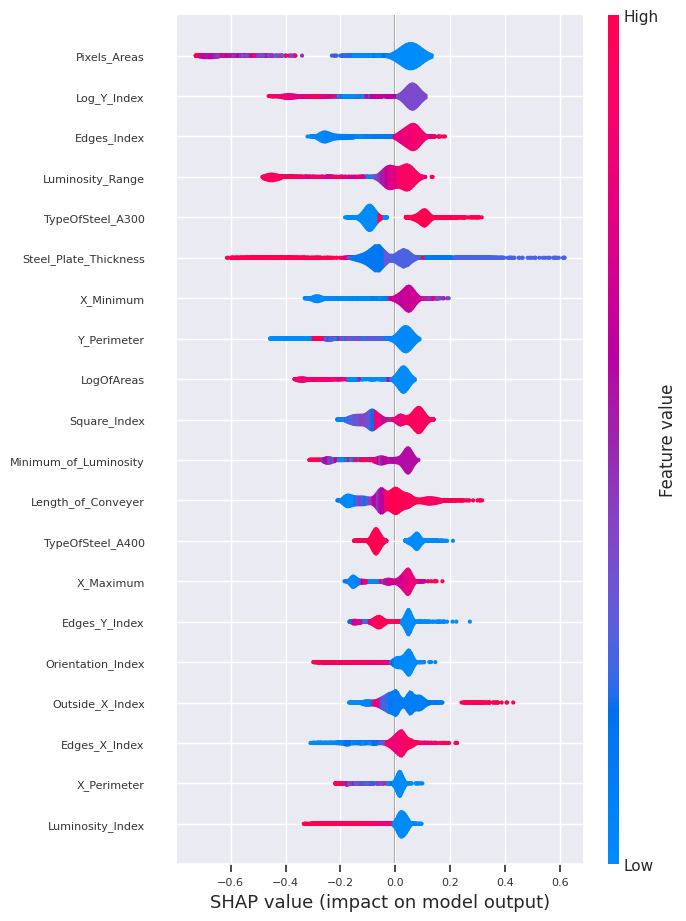


VIOLIN PLOT REPRESENTING <Other_Faults>


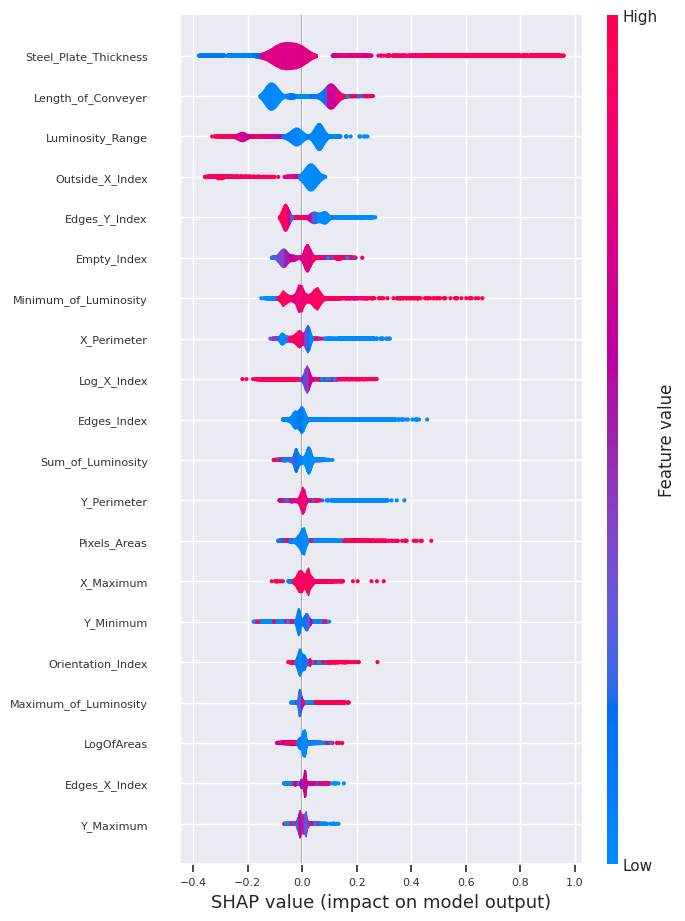

In [40]:
for k, target_label in enumerate(target_classes):
    print(f"VIOLIN PLOT REPRESENTING <{target_label}>")
    shap.summary_plot(shap_values[:,k, :-1], train.values,
                      plot_type="violin",
                      feature_names=feature_names, show=False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()
    print()

# 6.0 Preparation of the submission

In order to score higher, let's prepare an ensembled one with multiclass XGBoost and LightGBM and check if it improves our results by testing the blend on the out of fold predictions (oof).

### 6.1 Ensembling strategies

We first define a function that will calculate the out of fold predictions

In [41]:
def compute_oof(X, y, model, model_params, cv_strategy):
    
    cv_splits = cv_strategy.split(X, y=y)
    cv_oof = pd.DataFrame(np.zeros((len(y), len(target_classes))), columns=target_classes)
    
    for train_idx, val_idx in cv_splits:

        instantiated_model = model(**model_params)

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        instantiated_model.fit(X_train_fold, y_train_fold)

        y_val_prob = instantiated_model.predict_proba(X_val_fold)
        cv_oof.iloc[val_idx, :] = y_val_prob
    
    return cv_oof

We then compute first the predictions and oof for the XGBoost model

In [42]:
xgb_preds = xgb.predict_proba(test)
xgb_oof = compute_oof(train, target, XGBClassifier, best_cls_params, cv)

We then do the same for the LightGBM model (that we optimized elsewhere)

In [43]:
!pip -q install pyarrow_hotfix
import pyarrow_hotfix
from lightgbm import LGBMClassifier

Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.


In [44]:
parameters_dict = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": len(target_classes),
    "verbosity": -1,
    'n_estimators': 315, 
    'learning_rate': 0.038927375208580535, 
    'max_depth': 4, 
    'min_data_in_leaf': 274, 
    'subsample_freq': 9, 
    'feature_fraction': 0.36072715109677717, 
    'reg_lambda': 79.31416605346095, 
    'reg_alpha': 3.2965928880922615, 
    'subsample': 0.9862207095636681,
}

lgb = LGBMClassifier(**parameters_dict)

lgb.fit(train, target)
lgb_preds = lgb.predict_proba(test)

lgb_oof = compute_oof(train, target, LGBMClassifier, parameters_dict, cv)

At this point we normalize in the range 0-1 all the predictions and oof predictions. This is necessary because, since predictions are probabilities (and each model may treat the problem differently), we need to rescale them so they can be treated as a ranking across different models. This avoids that a prediction may dominate others.

In [45]:
xgb_oof = MinMaxScaler().fit_transform(xgb_oof)
lgb_oof = MinMaxScaler().fit_transform(lgb_oof)
xgb_preds = MinMaxScaler().fit_transform(xgb_preds)
lgb_preds = MinMaxScaler().fit_transform(lgb_preds)

In [46]:
xgb_score = roc_auc_score(targets_bin, xgb_oof[:, 1:], multi_class='ovr')
lgb_score = roc_auc_score(targets_bin, lgb_oof[:, 1:], multi_class='ovr')

print(f"oof roc-auc score for XGB  model: {xgb_score:0.5f}")
print(f"oof roc-auc score for LGBM model: {lgb_score:0.5f}")

oof roc-auc score for XGB  model: 0.88870
oof roc-auc score for LGBM model: 0.88816


As a starting attempt, we simply blend with an average the two models. Using Nelder-Mean optimization, we figure out how to weight XGBoost and LightGBM predictions to obtain the best result. The strategy is to optimize for ROC-AUC each target separately, since they are independent.

In [47]:
from functools import partial
from scipy.optimize import minimize

blend = np.zeros((xgb_oof.shape[0], xgb_oof.shape[1]-1))
preds = np.zeros((xgb_preds.shape[0], xgb_preds.shape[1]-1))

initial_weights = np.array([0.5, 0.5])

def calculate_roc_auc(weights, oof_1, oof_2, target):
    # Normalize weights
    weights /= np.sum(weights)
    
    # Calculate weighted sum
    weighted_sum = oof_1 * weights[0] + oof_2 * weights[1]
    
    # Calculate ROC AUC score
    score = roc_auc_score(target, weighted_sum)
    
    # Return the sum of ROC AUC scores
    return score * -1  # Minimize negative sum to maximize sum of ROC AUC scores

# Define bounds for each weight (greater than or equal to 0)
bounds = [(0, None), (0, None)]

for k in range(len(target_classes)-1):
    result = minimize(partial(calculate_roc_auc, 
                              oof_1=xgb_oof[:, k + 1],
                              oof_2=lgb_oof[:, k + 1],
                              target=targets_bin.iloc[:, k]), 
                      initial_weights, 
                      method='Nelder-Mead',
                      bounds=bounds)
    
    optimal_weights = result.x / np.sum(result.x)
    
    print(f"{target_classes[k + 1]} : XGB={optimal_weights[0]:0.3f}, LGBM={optimal_weights[1]:0.3f}")
    blend[:, k] = (xgb_oof[:, k + 1] * optimal_weights[0] + lgb_oof[:, k + 1] * optimal_weights[1])
    preds[:, k] = (xgb_preds[:, k + 1] * optimal_weights[0] + lgb_preds[:, k + 1] * optimal_weights[1])

Pastry : XGB=0.692, LGBM=0.308
Z_Scratch : XGB=0.927, LGBM=0.073
K_Scatch : XGB=0.000, LGBM=1.000
Stains : XGB=0.705, LGBM=0.295
Dirtiness : XGB=0.704, LGBM=0.296
Bumps : XGB=0.429, LGBM=0.571
Other_Faults : XGB=0.474, LGBM=0.526


In [48]:
blend_score = roc_auc_score(targets_bin, blend, multi_class='ovr')
print(f"oof roc-auc score for blend of models: {blend_score:0.5f}")

oof roc-auc score for blend of models: 0.88920


### 6.2 Preparing the submission file

In [49]:
submission = pd.read_csv("/kaggle/input/playground-series-s4e3/sample_submission.csv")
submission.iloc[:, 1:] = preds
submission.to_csv("xgb_submission.csv", index=False)

In [50]:
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.660718,0.001080,0.001957,0.000179,0.016467,0.157850,0.311736
1,19220,0.325214,0.022983,0.014417,0.000416,0.244002,0.200913,0.358518
2,19221,0.004598,0.055068,0.036408,0.000973,0.014224,0.389569,0.591016
3,19222,0.222719,0.001942,0.001492,0.001936,0.017758,0.450443,0.470263
4,19223,0.003090,0.002037,0.001753,0.003551,0.008140,0.736565,0.376247
